In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

from scipy.stats import zscore, binned_statistic
from scipy.ndimage import gaussian_filter1d

ModuleNotFoundError: No module named 'memory_profiler'

In [2]:
pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'

x = pd.read_csv('/home/ngr4/project/scnd/results/top100_dyngenes_v3.csv', index_col=0)

ntimebins=20
cm = plt.get_cmap('magma')
timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

['/home/ngr4/project/scnd/results/top100_dyngenes_v3.csv']

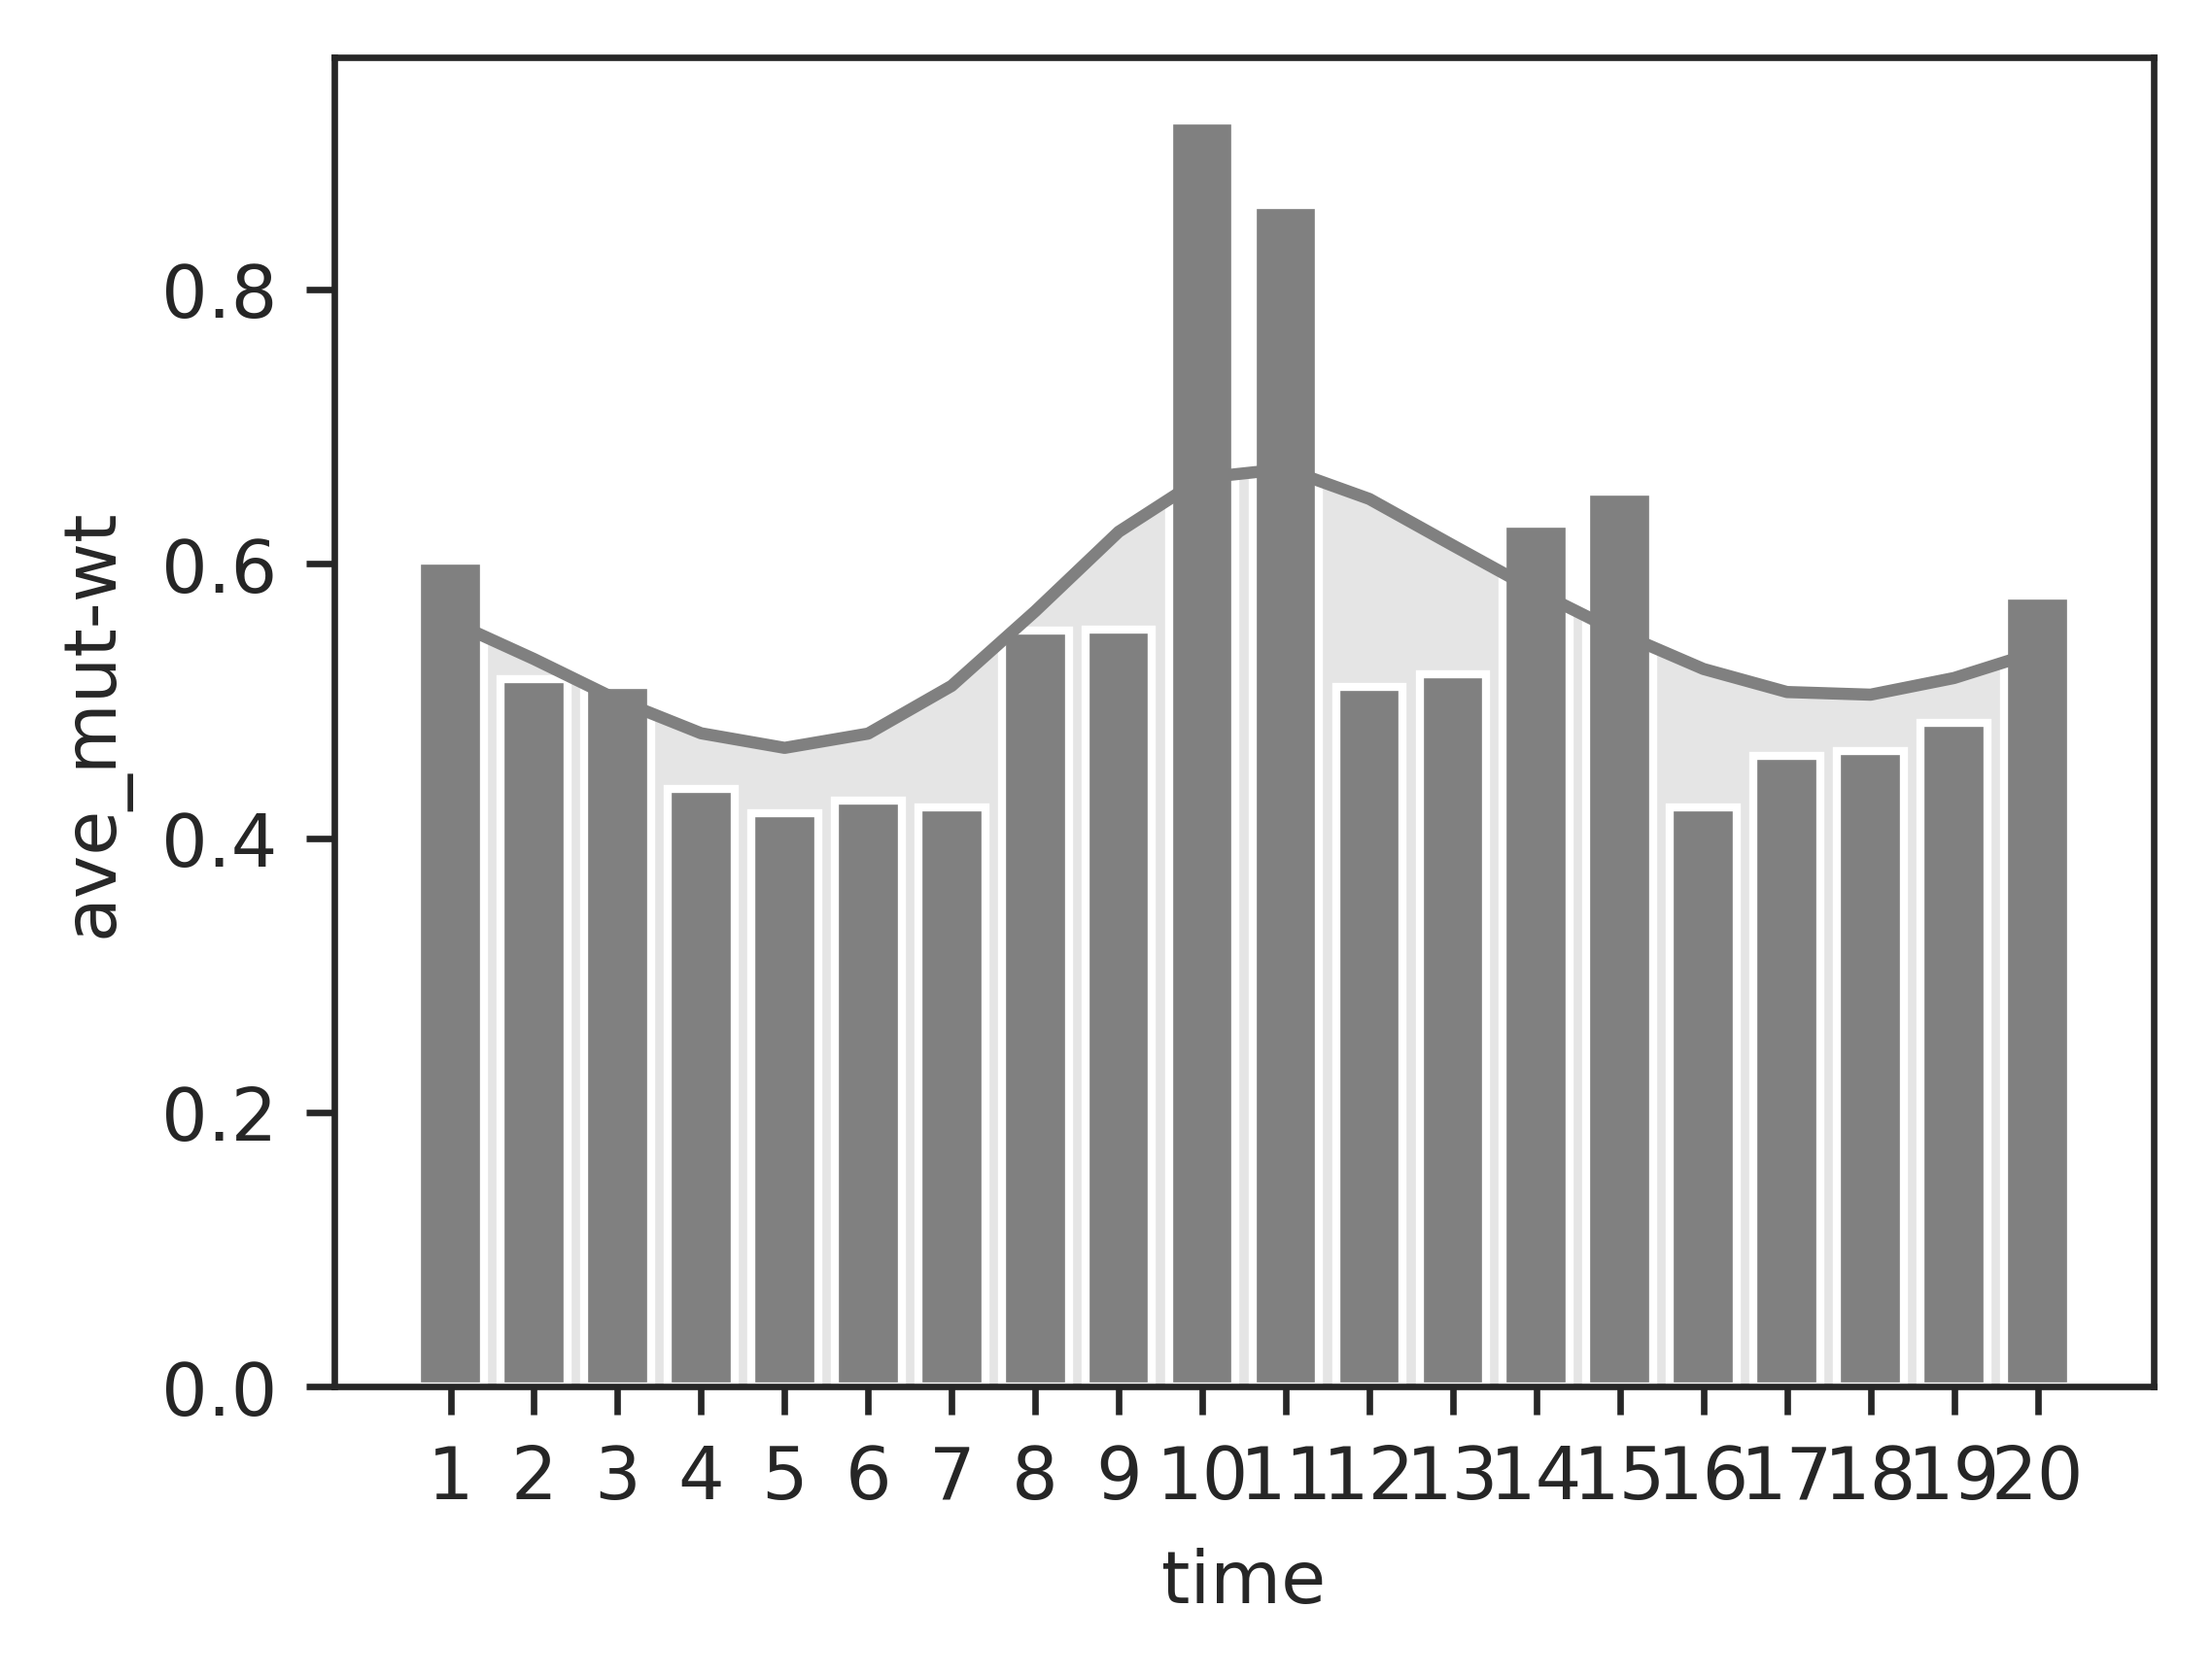

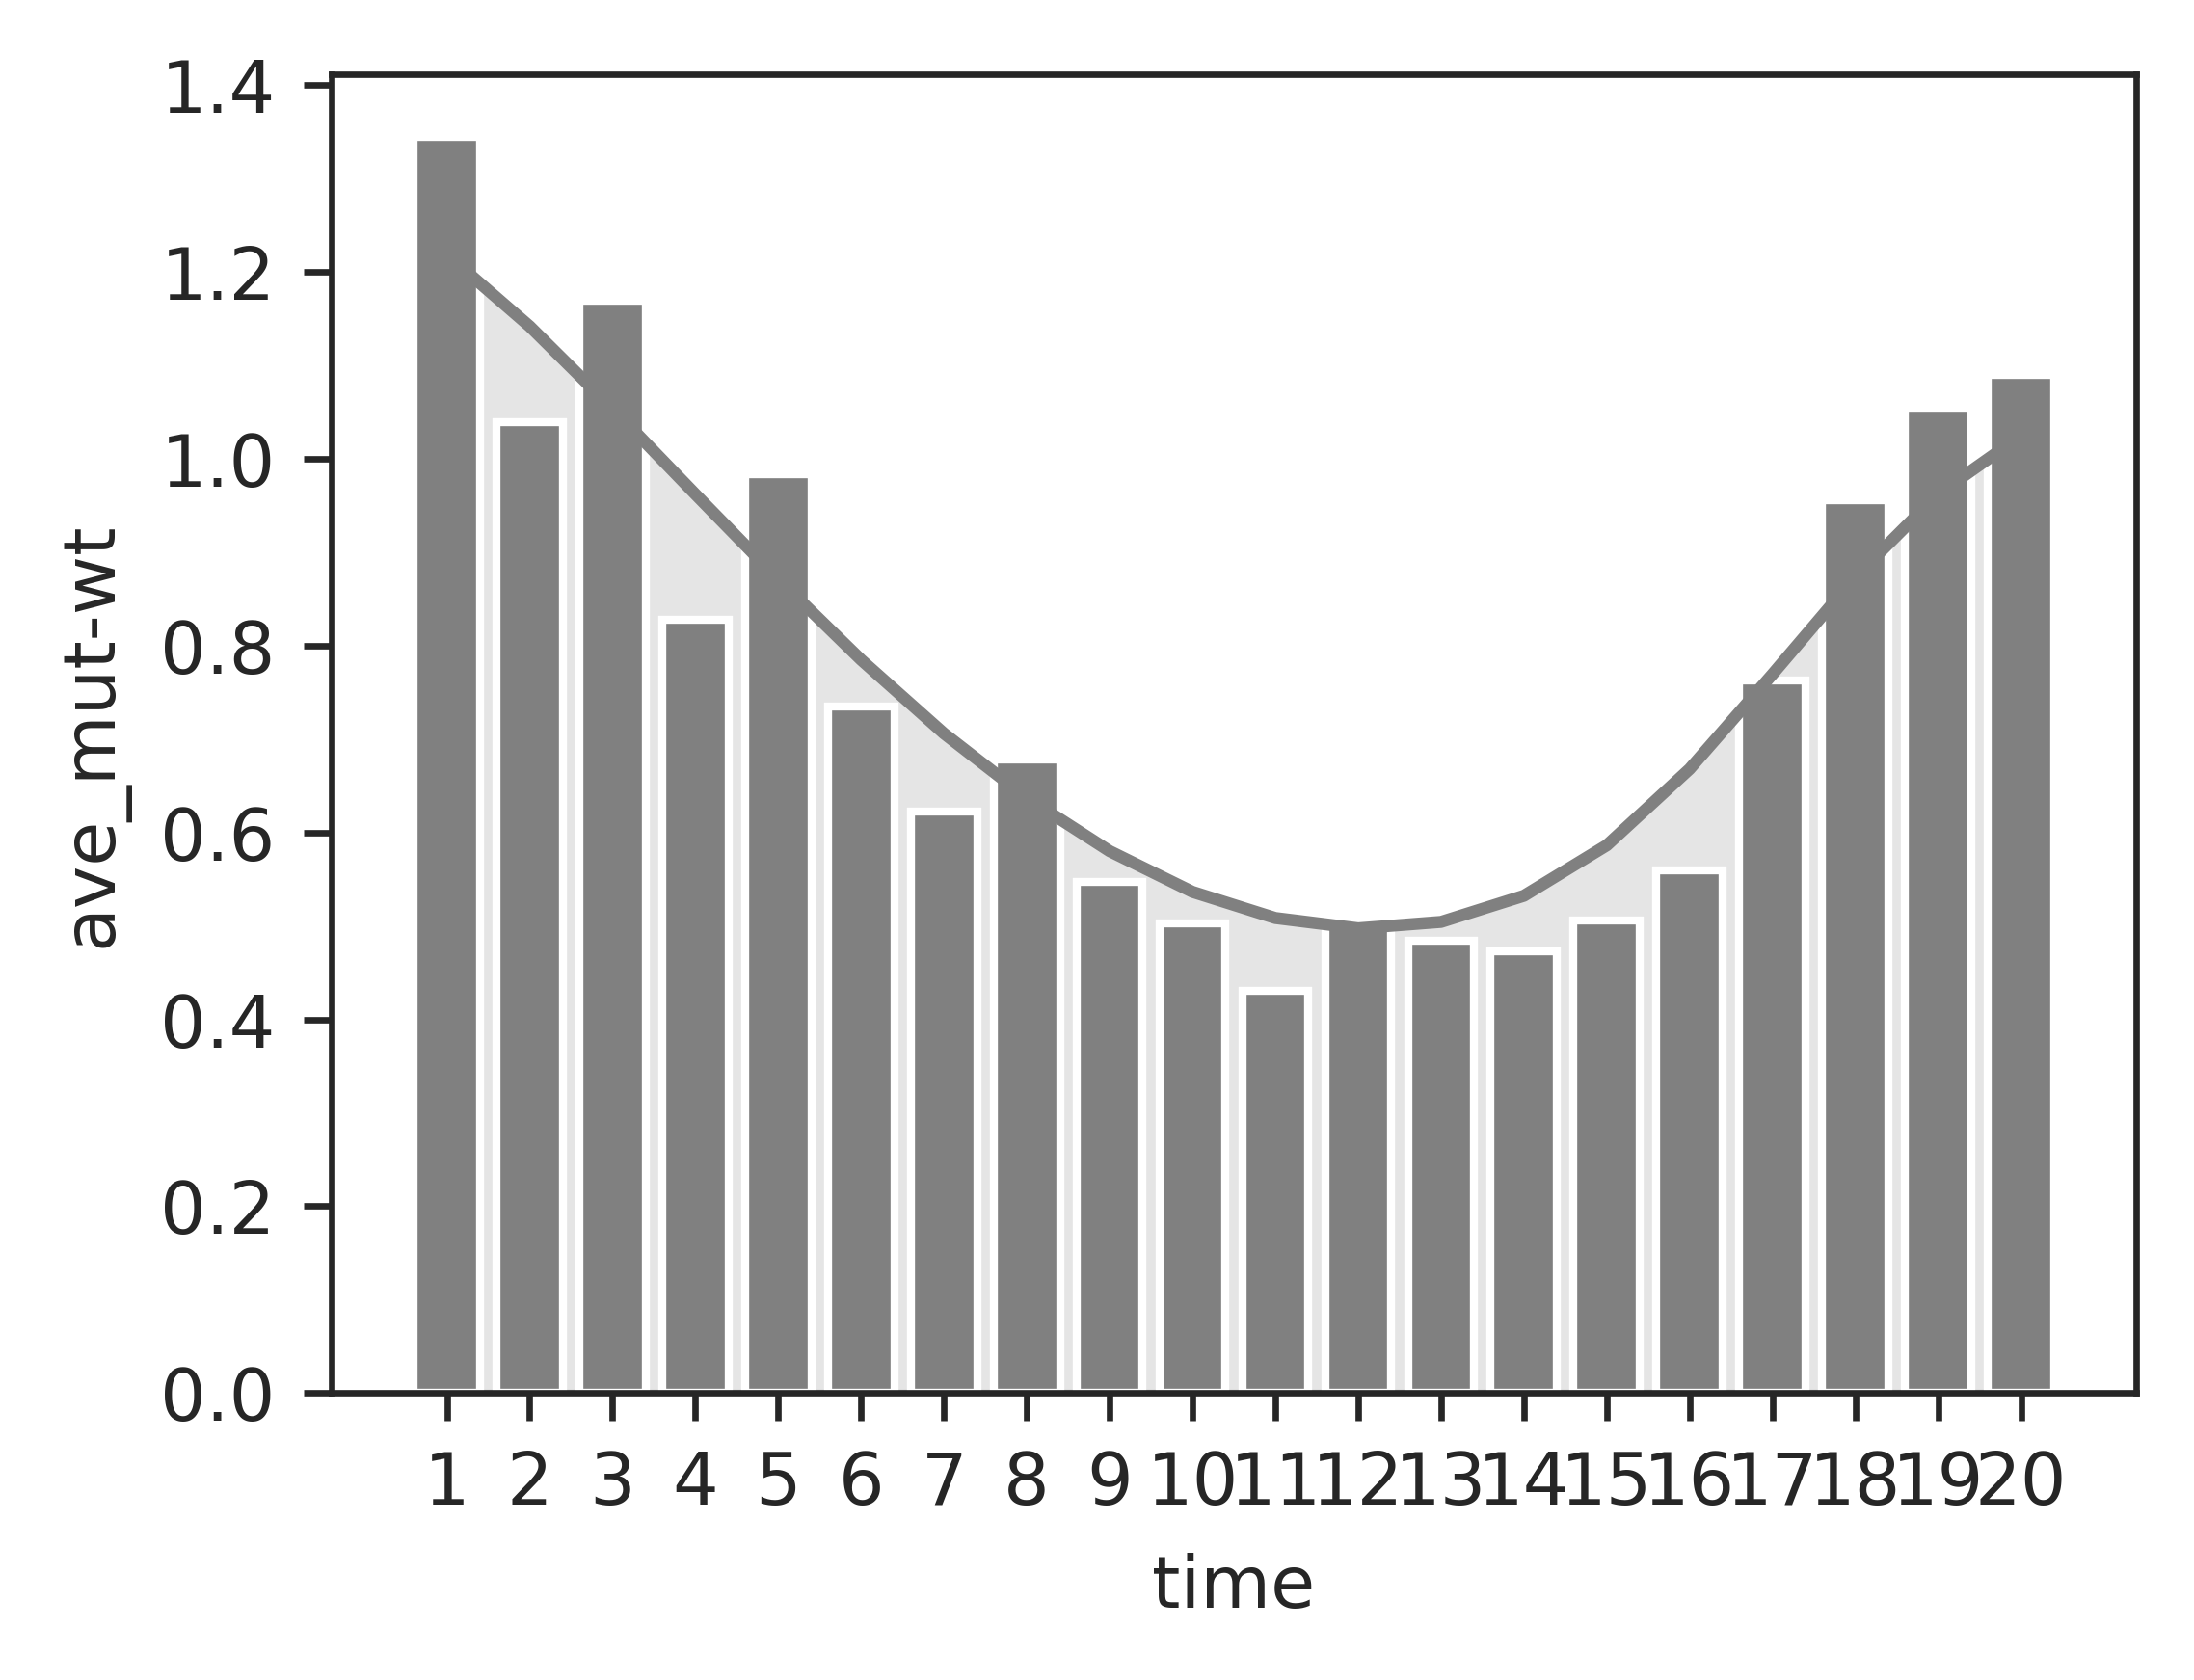

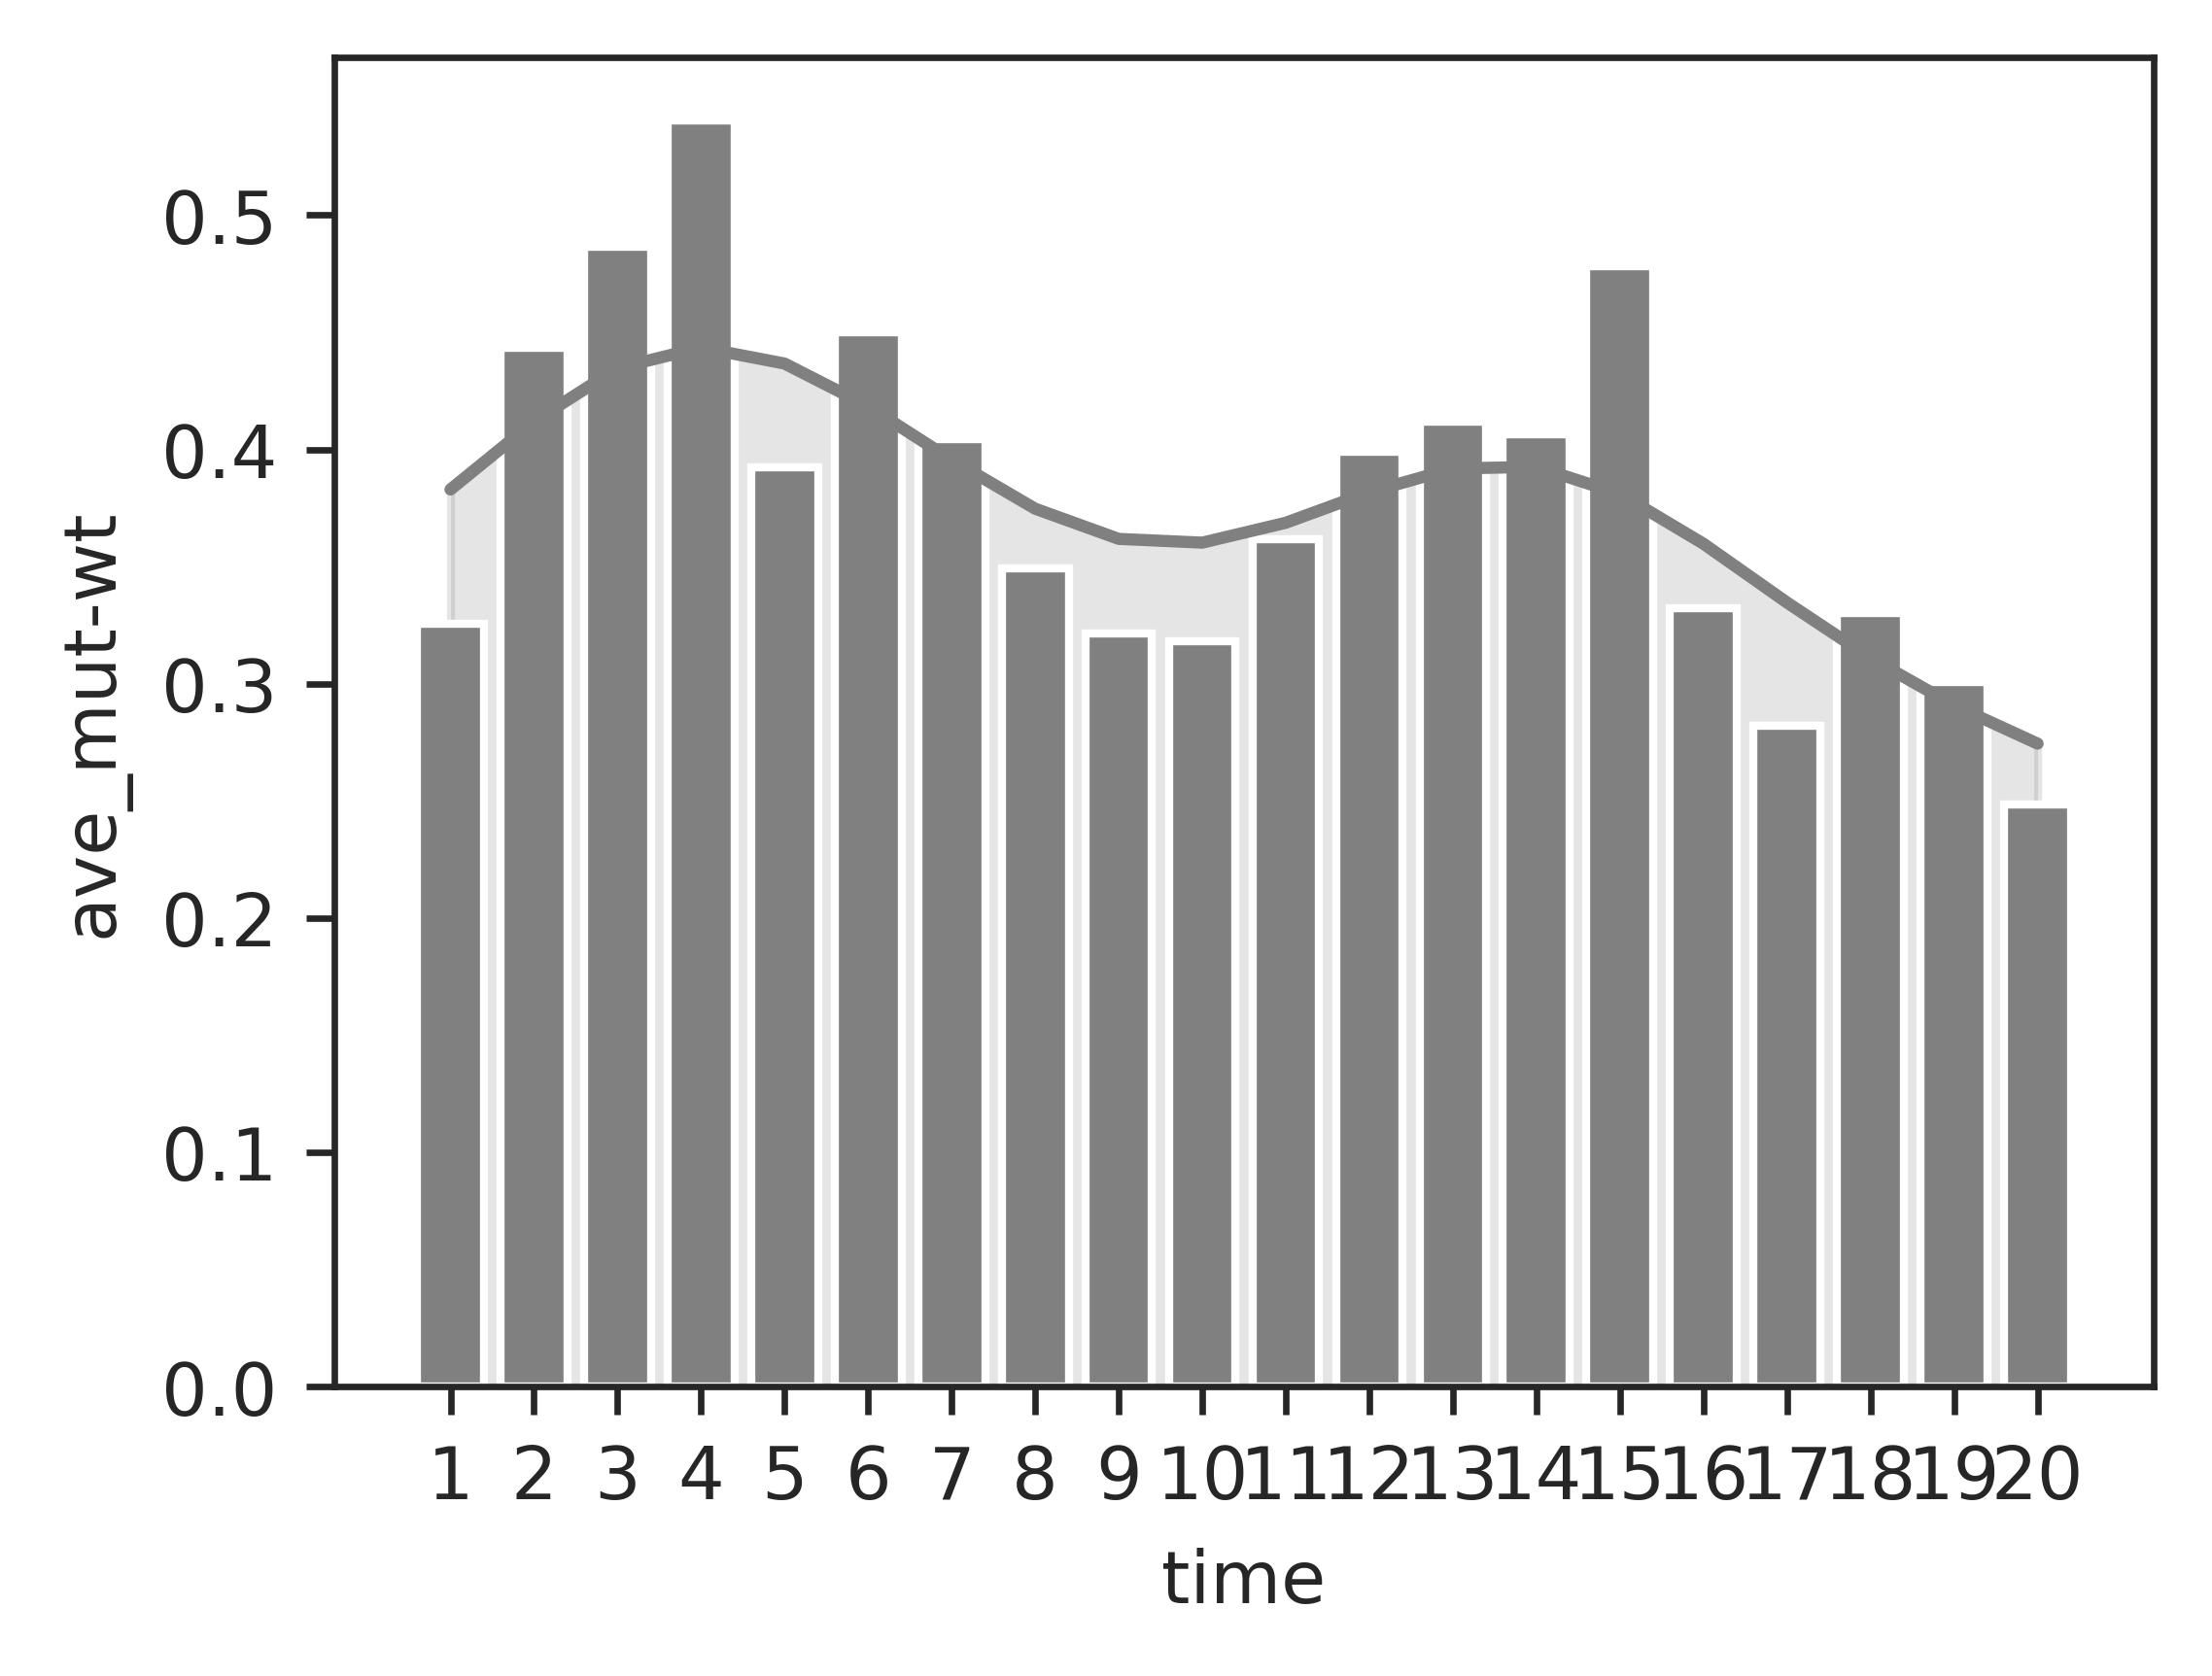

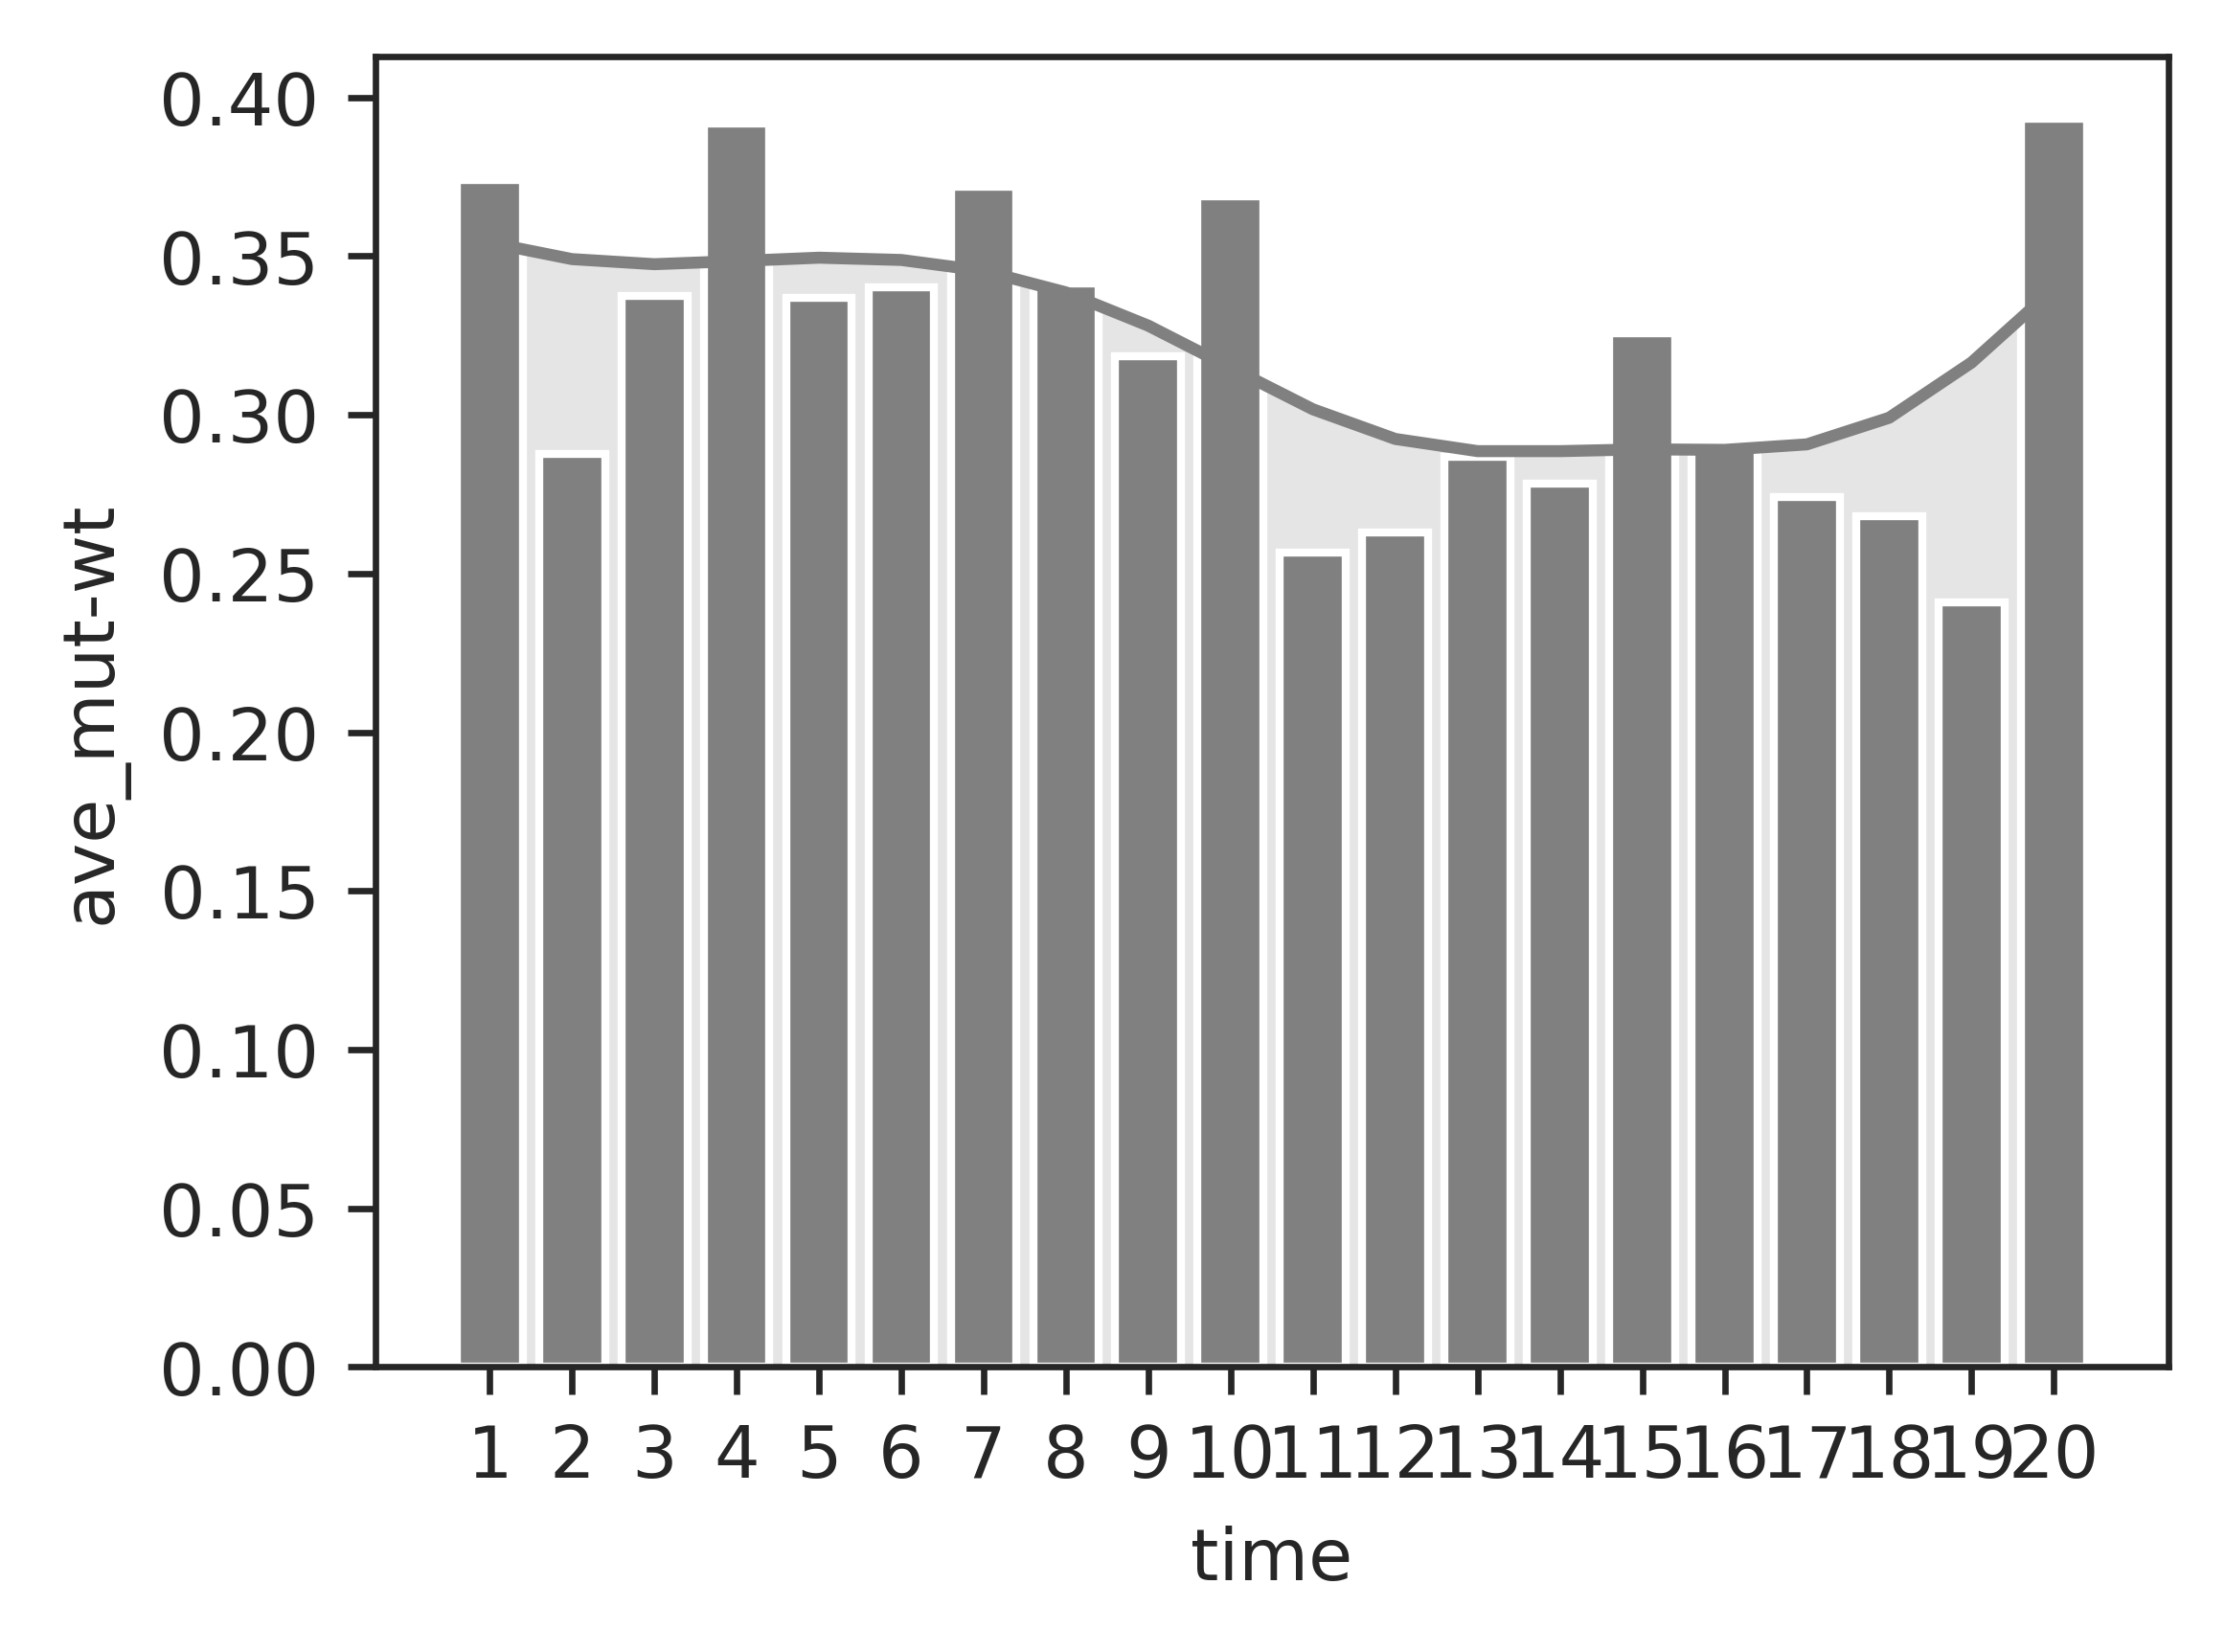

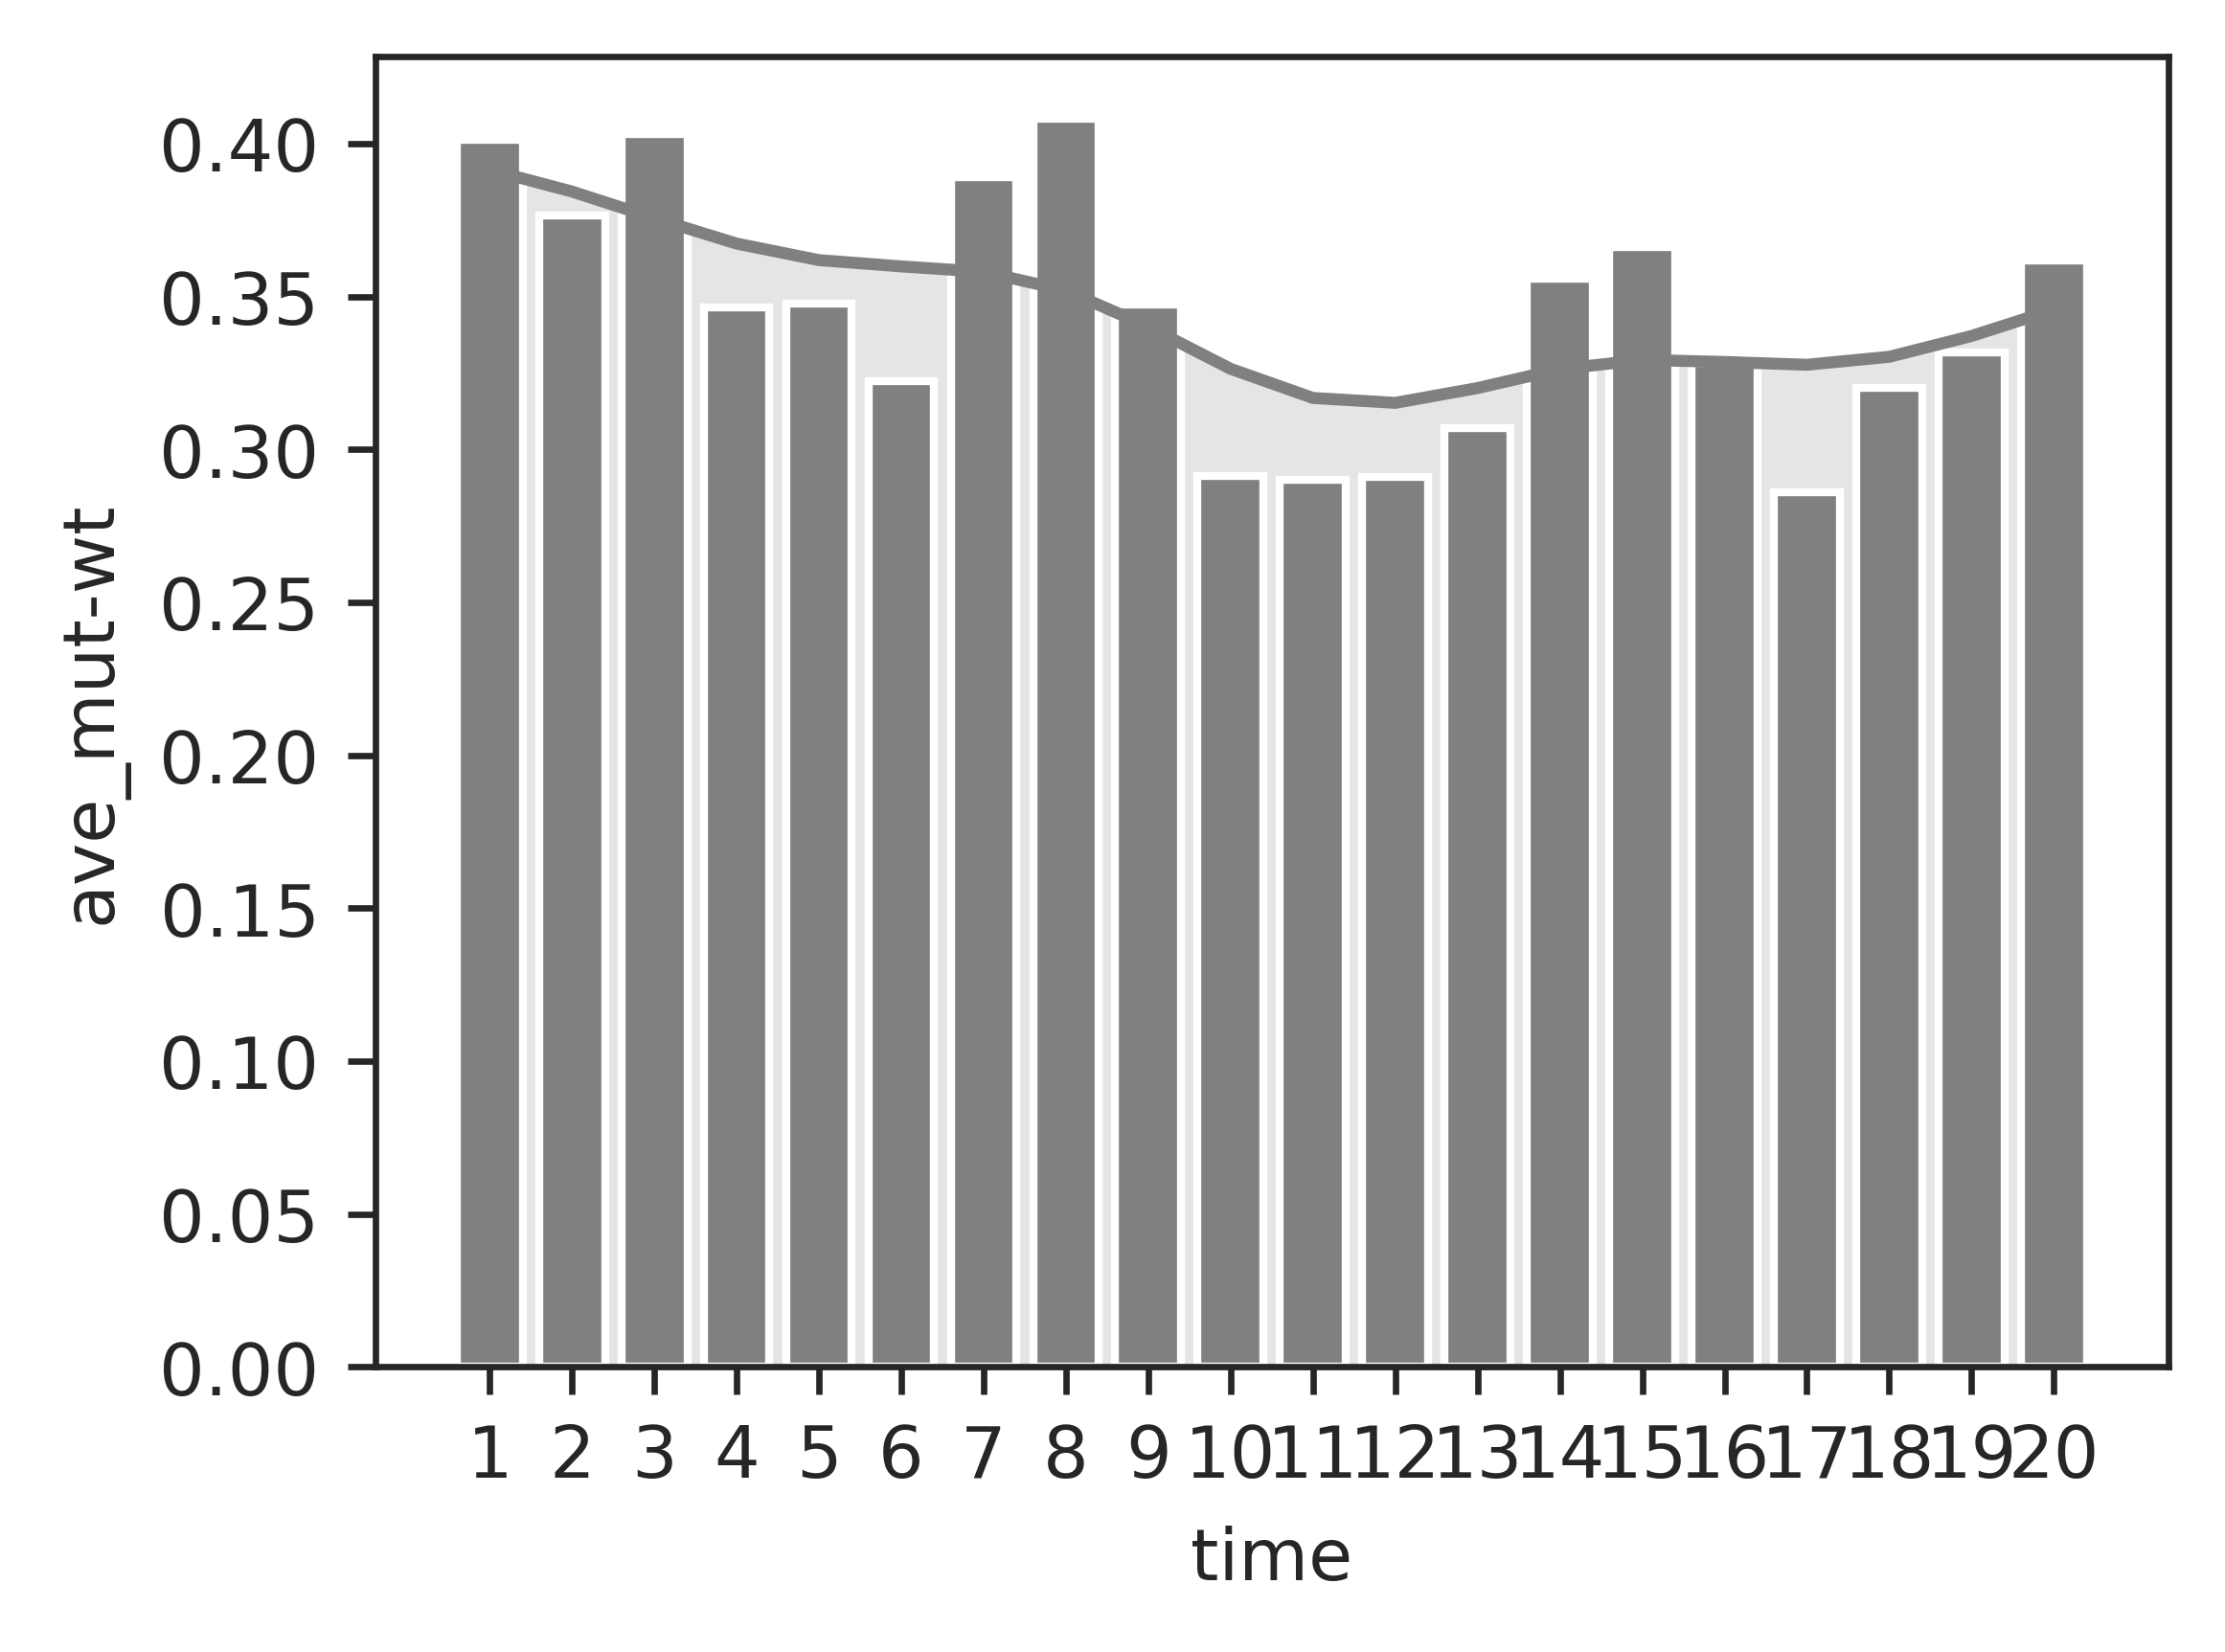

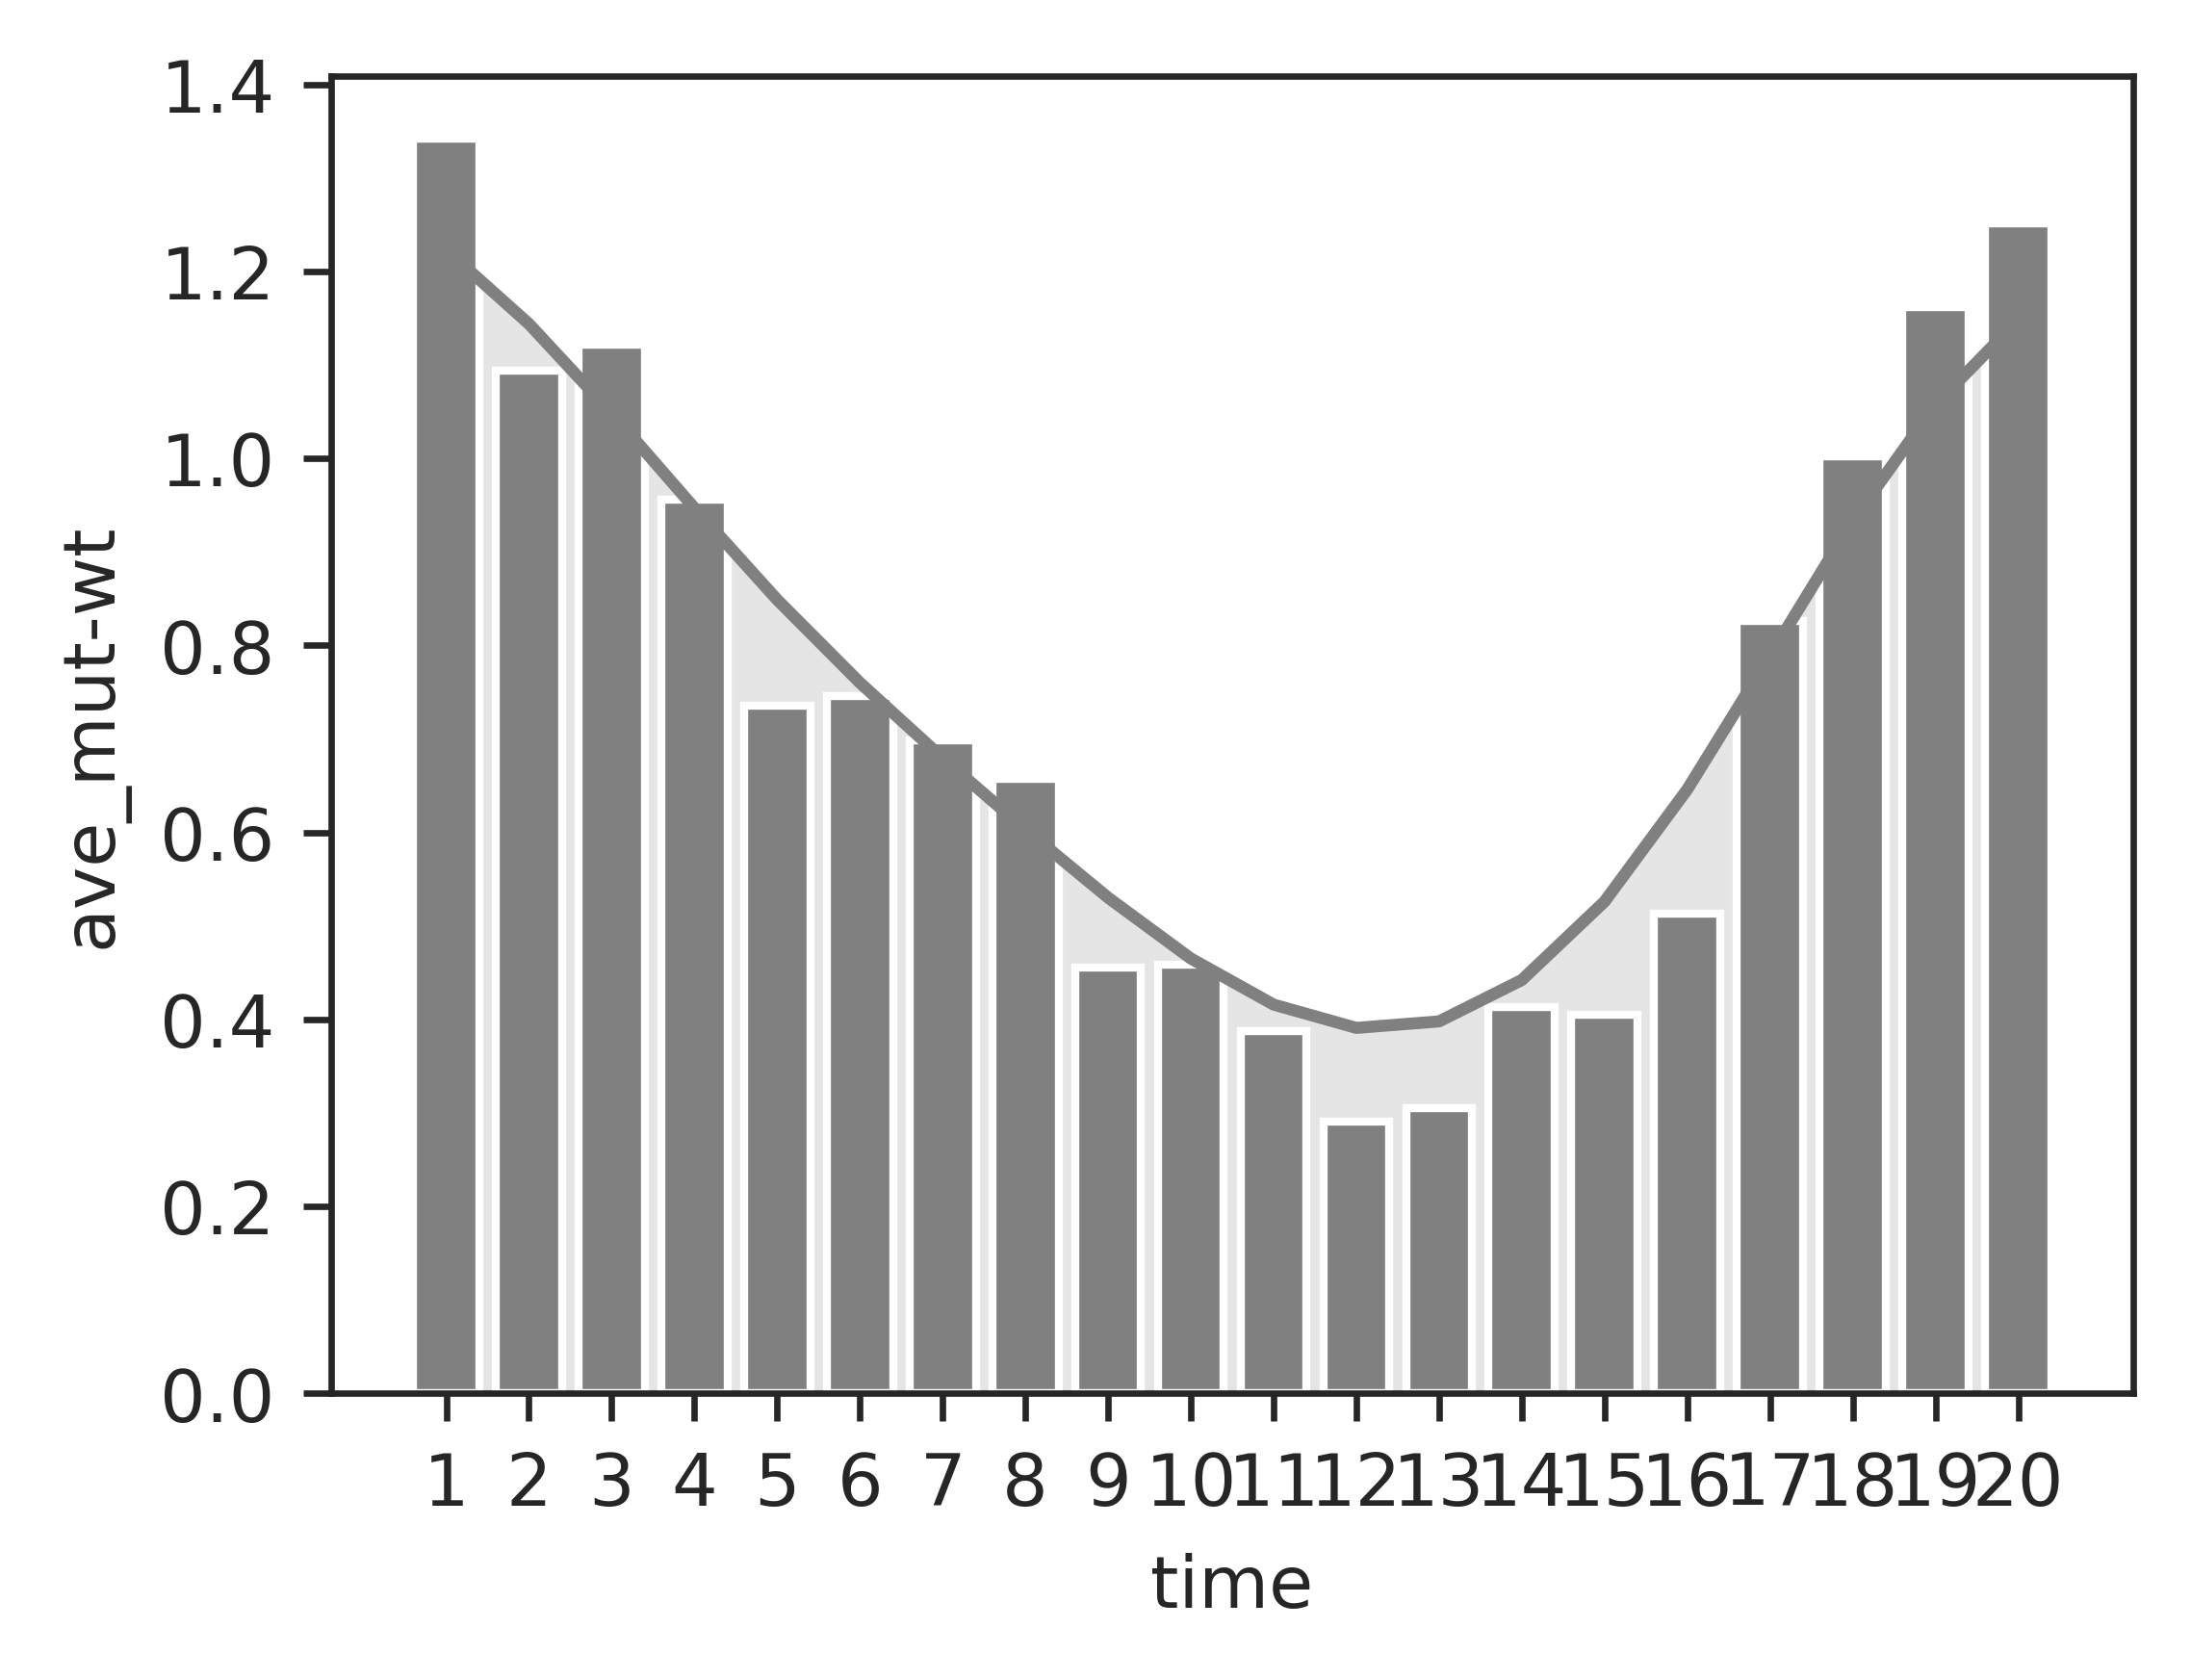

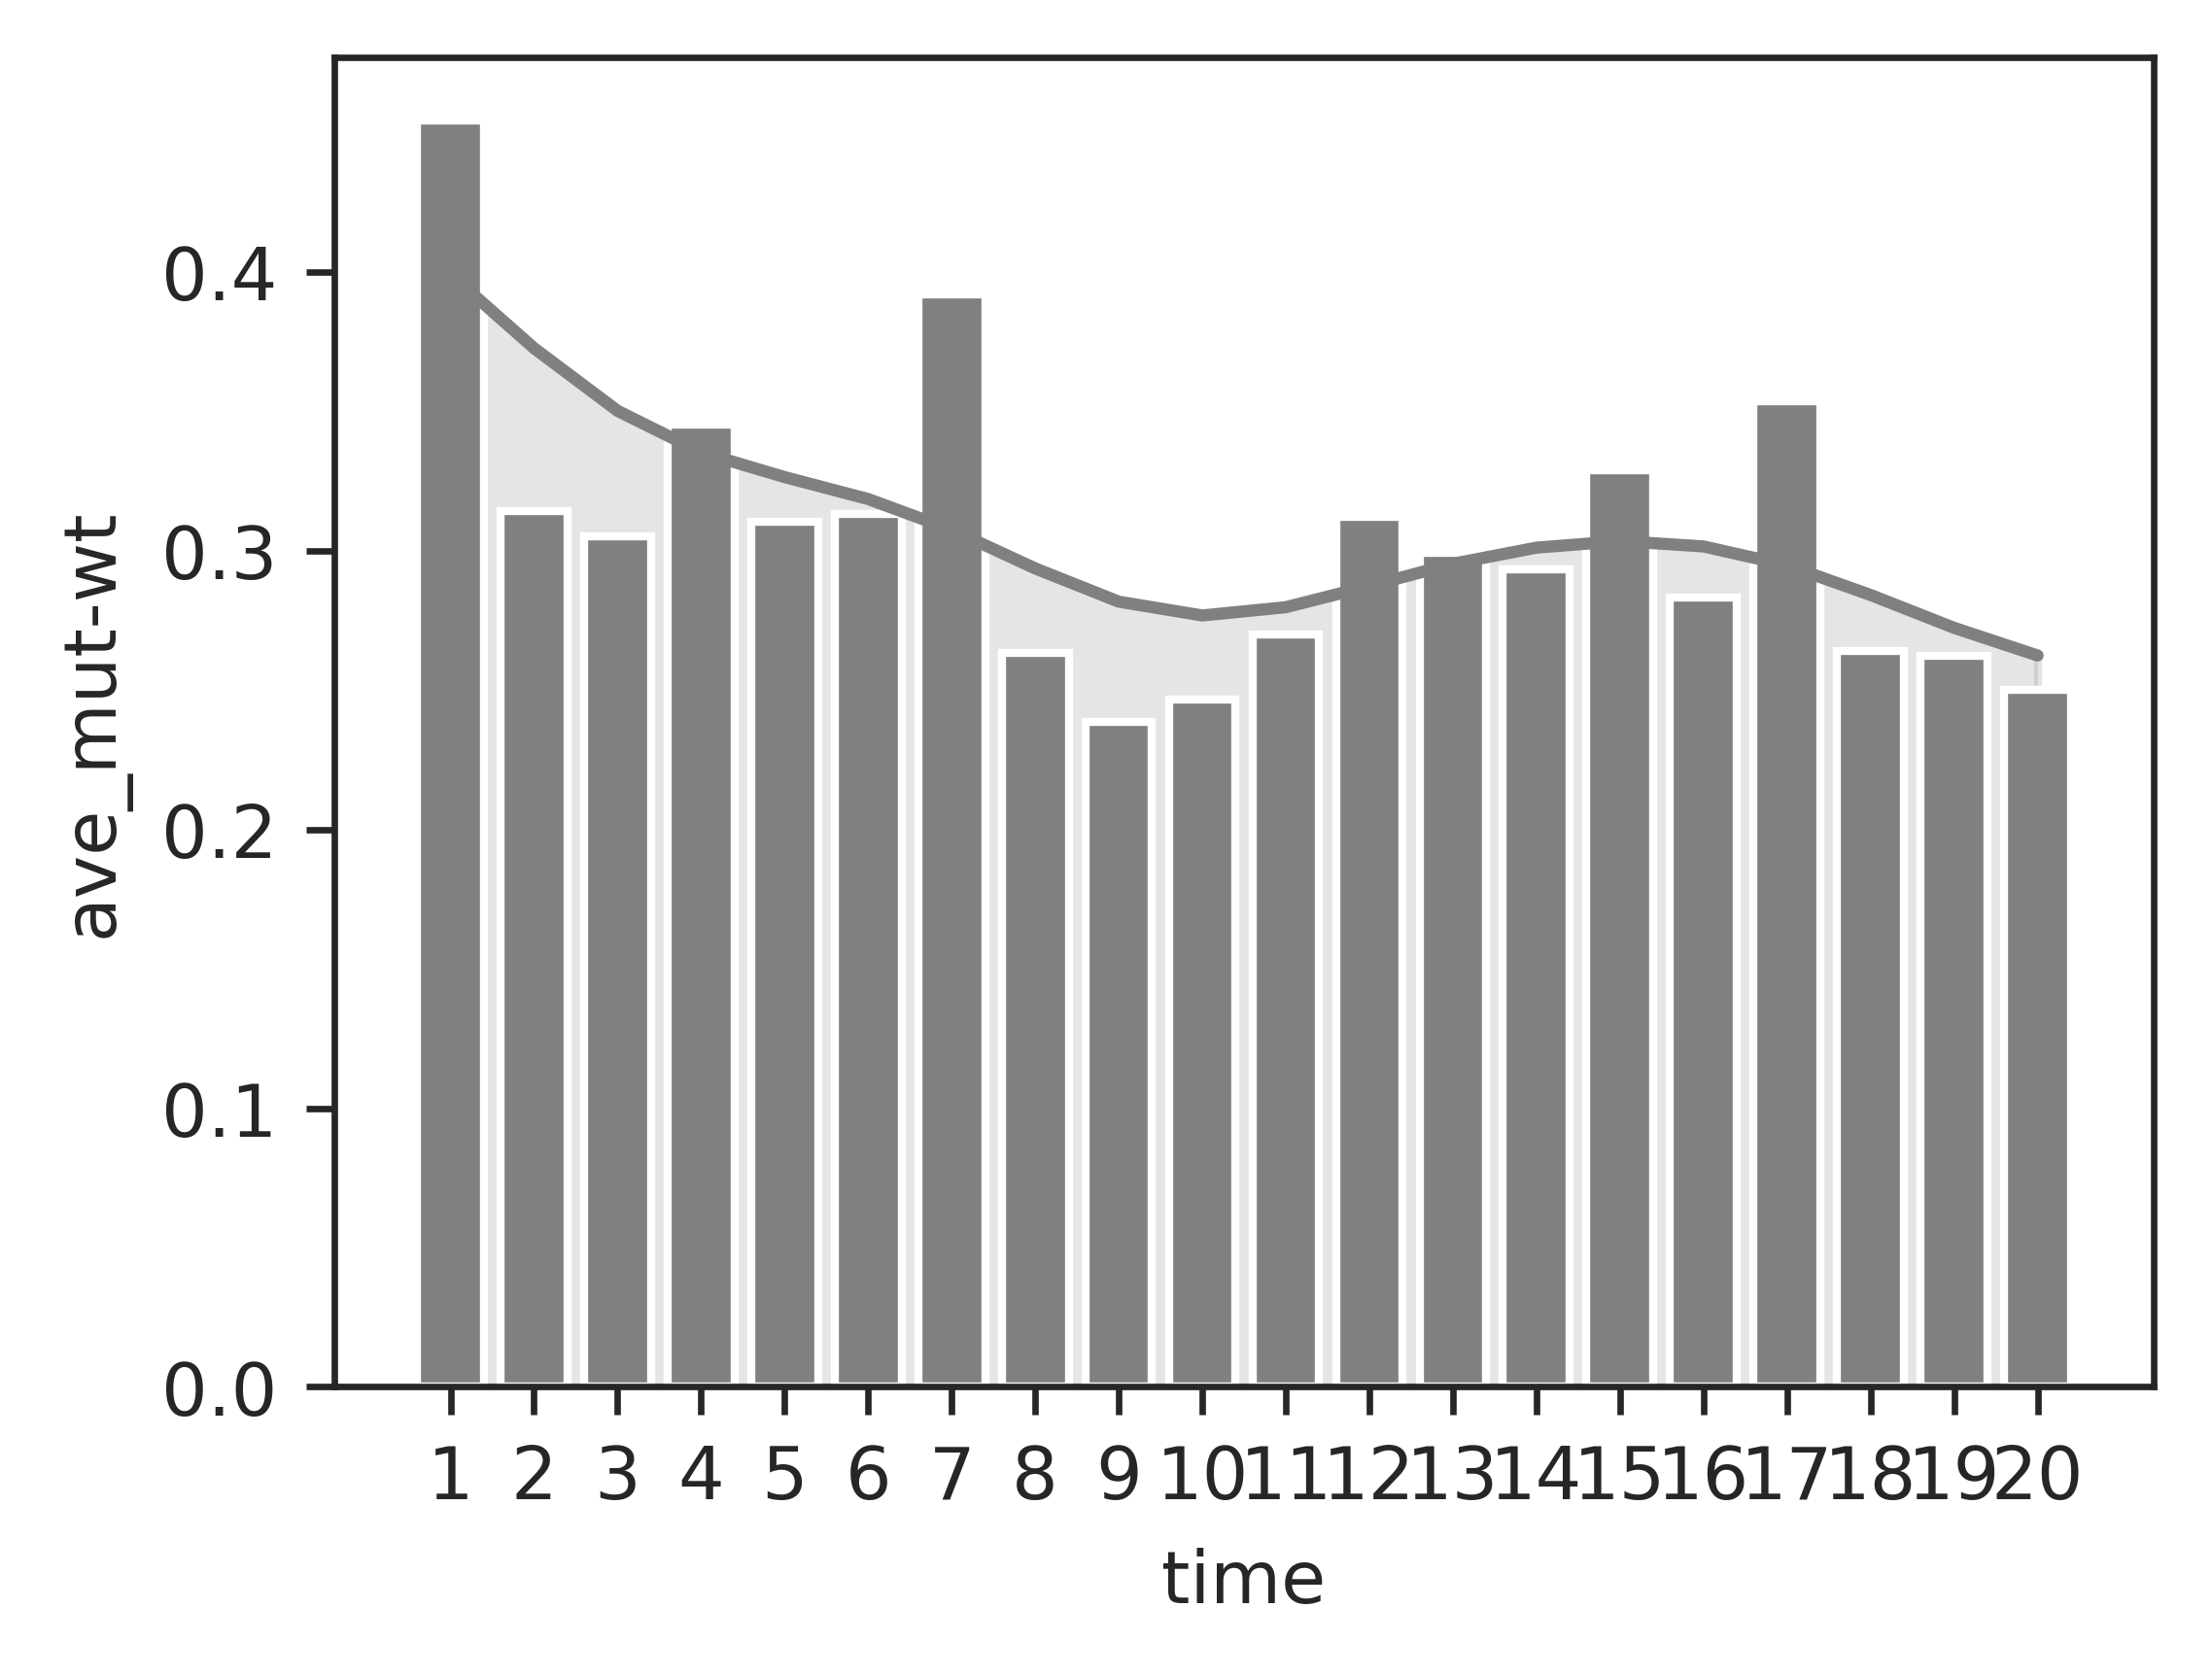

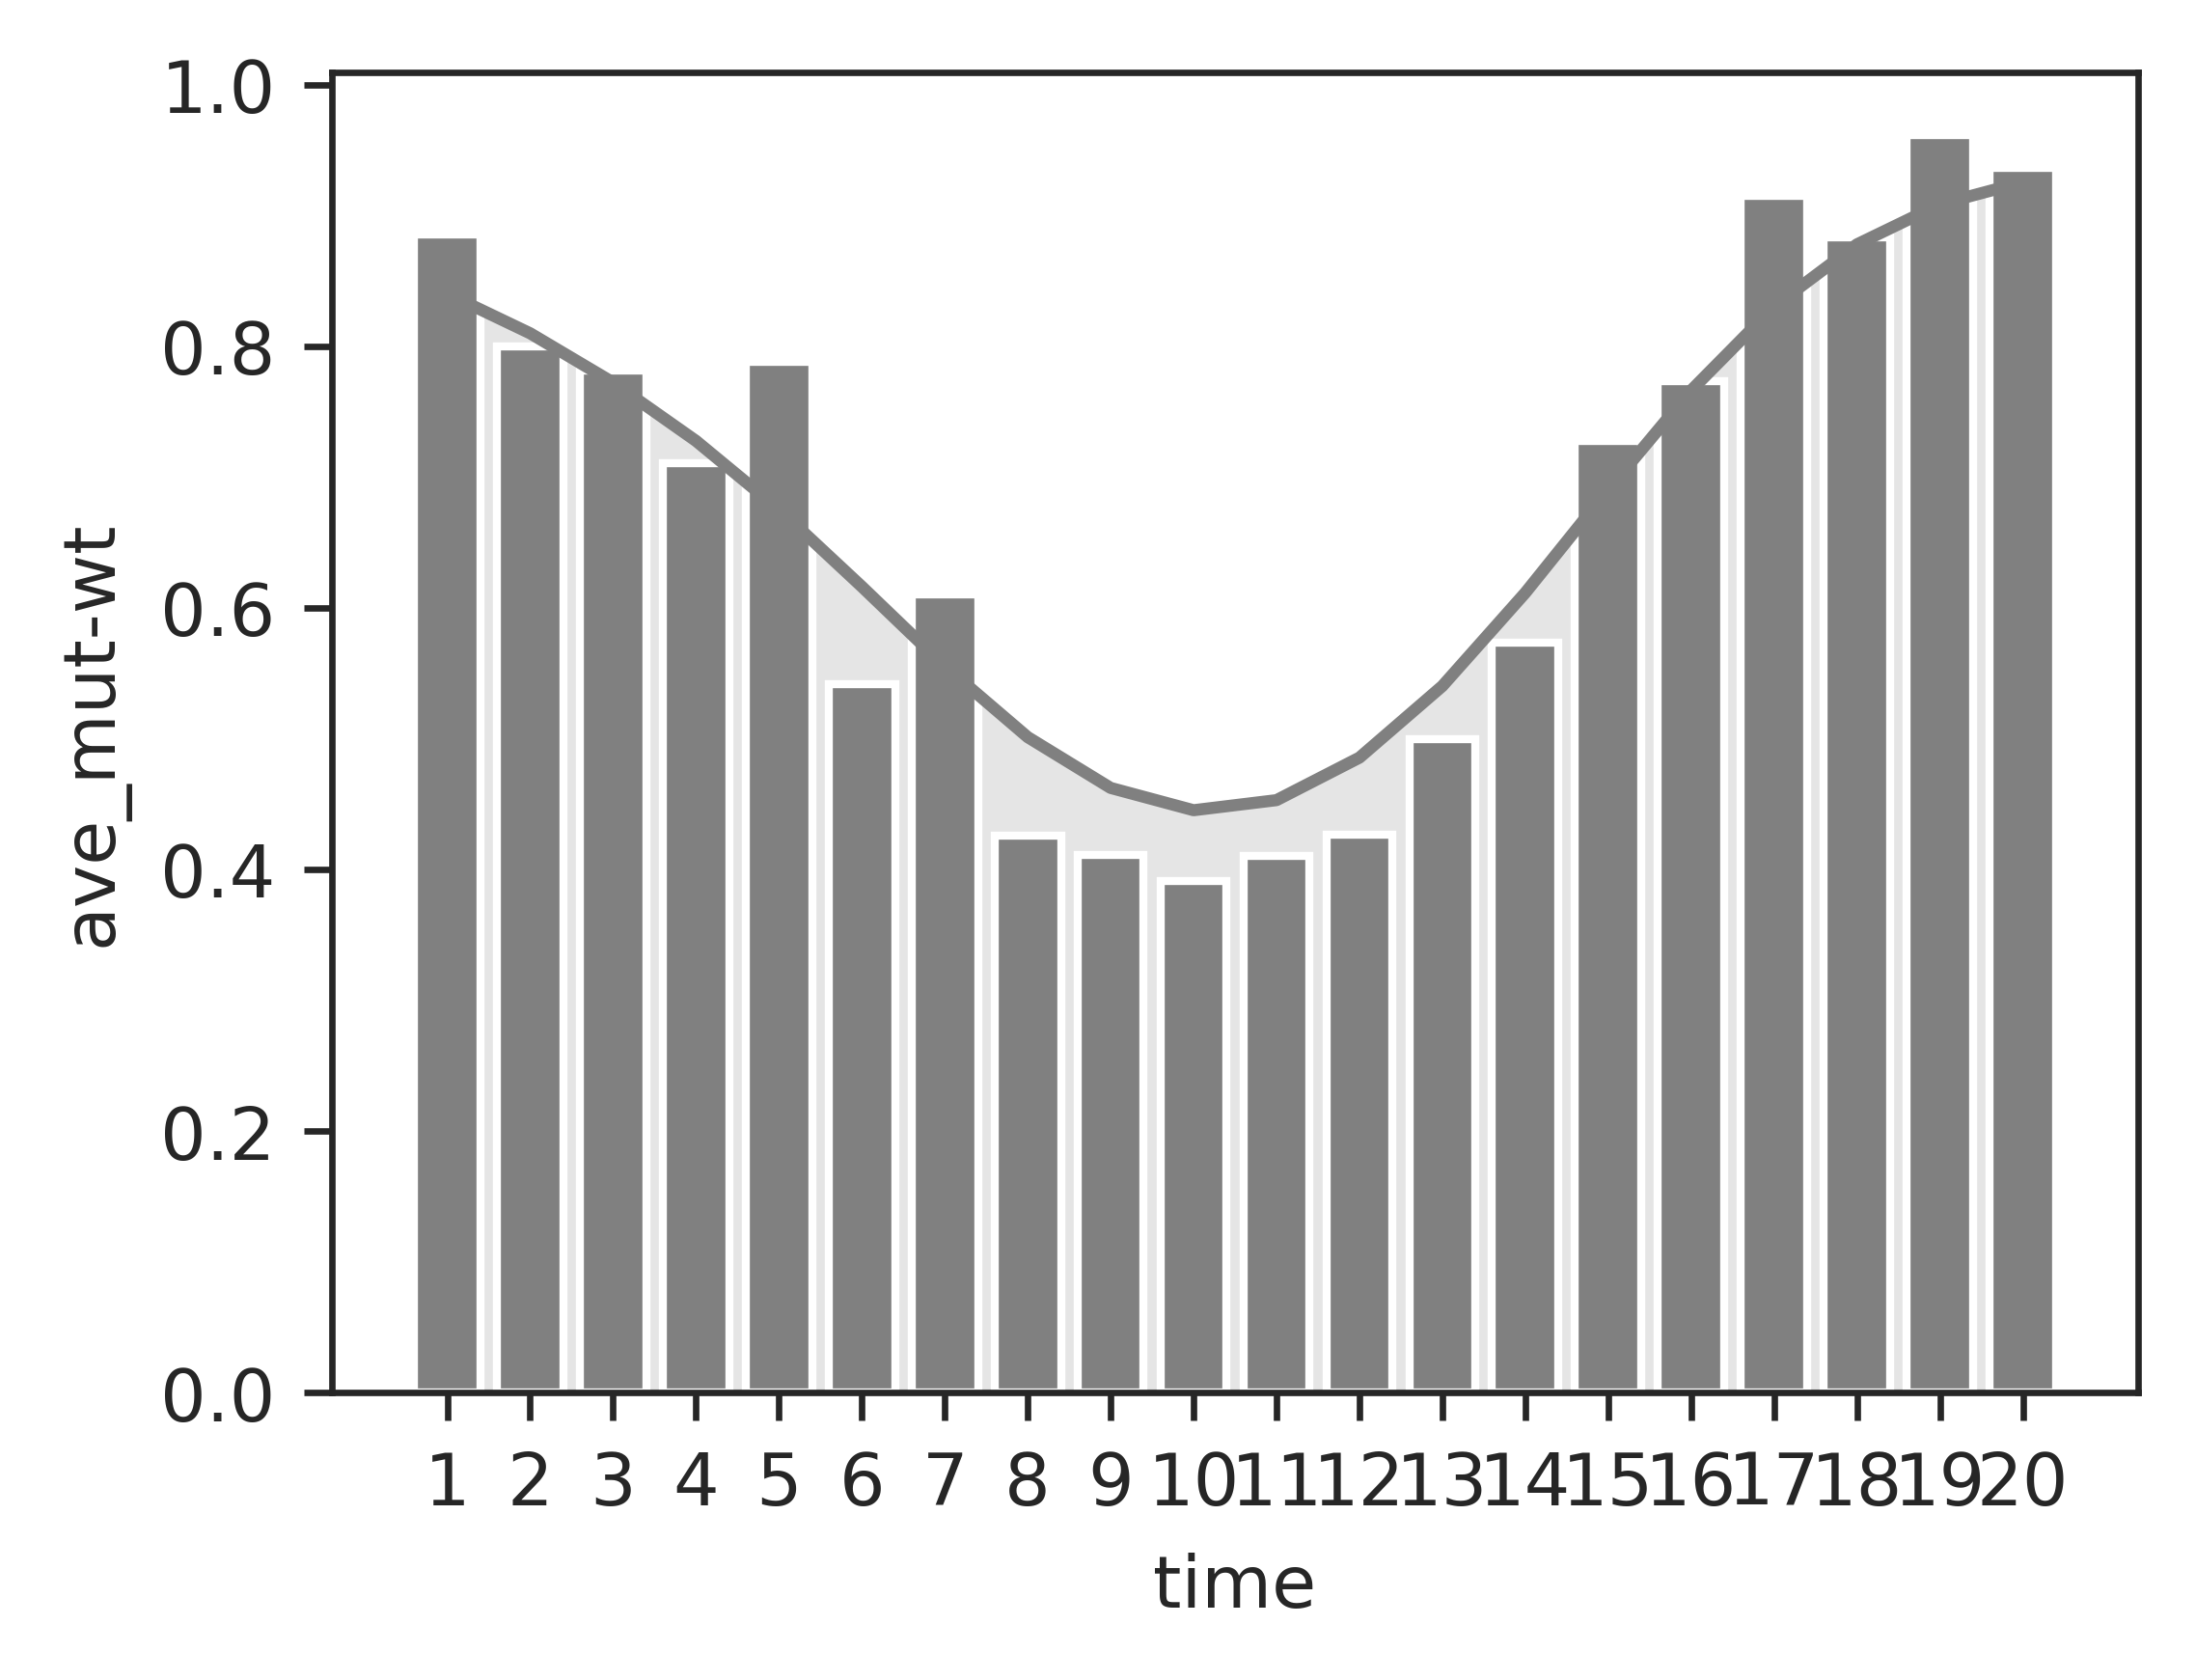

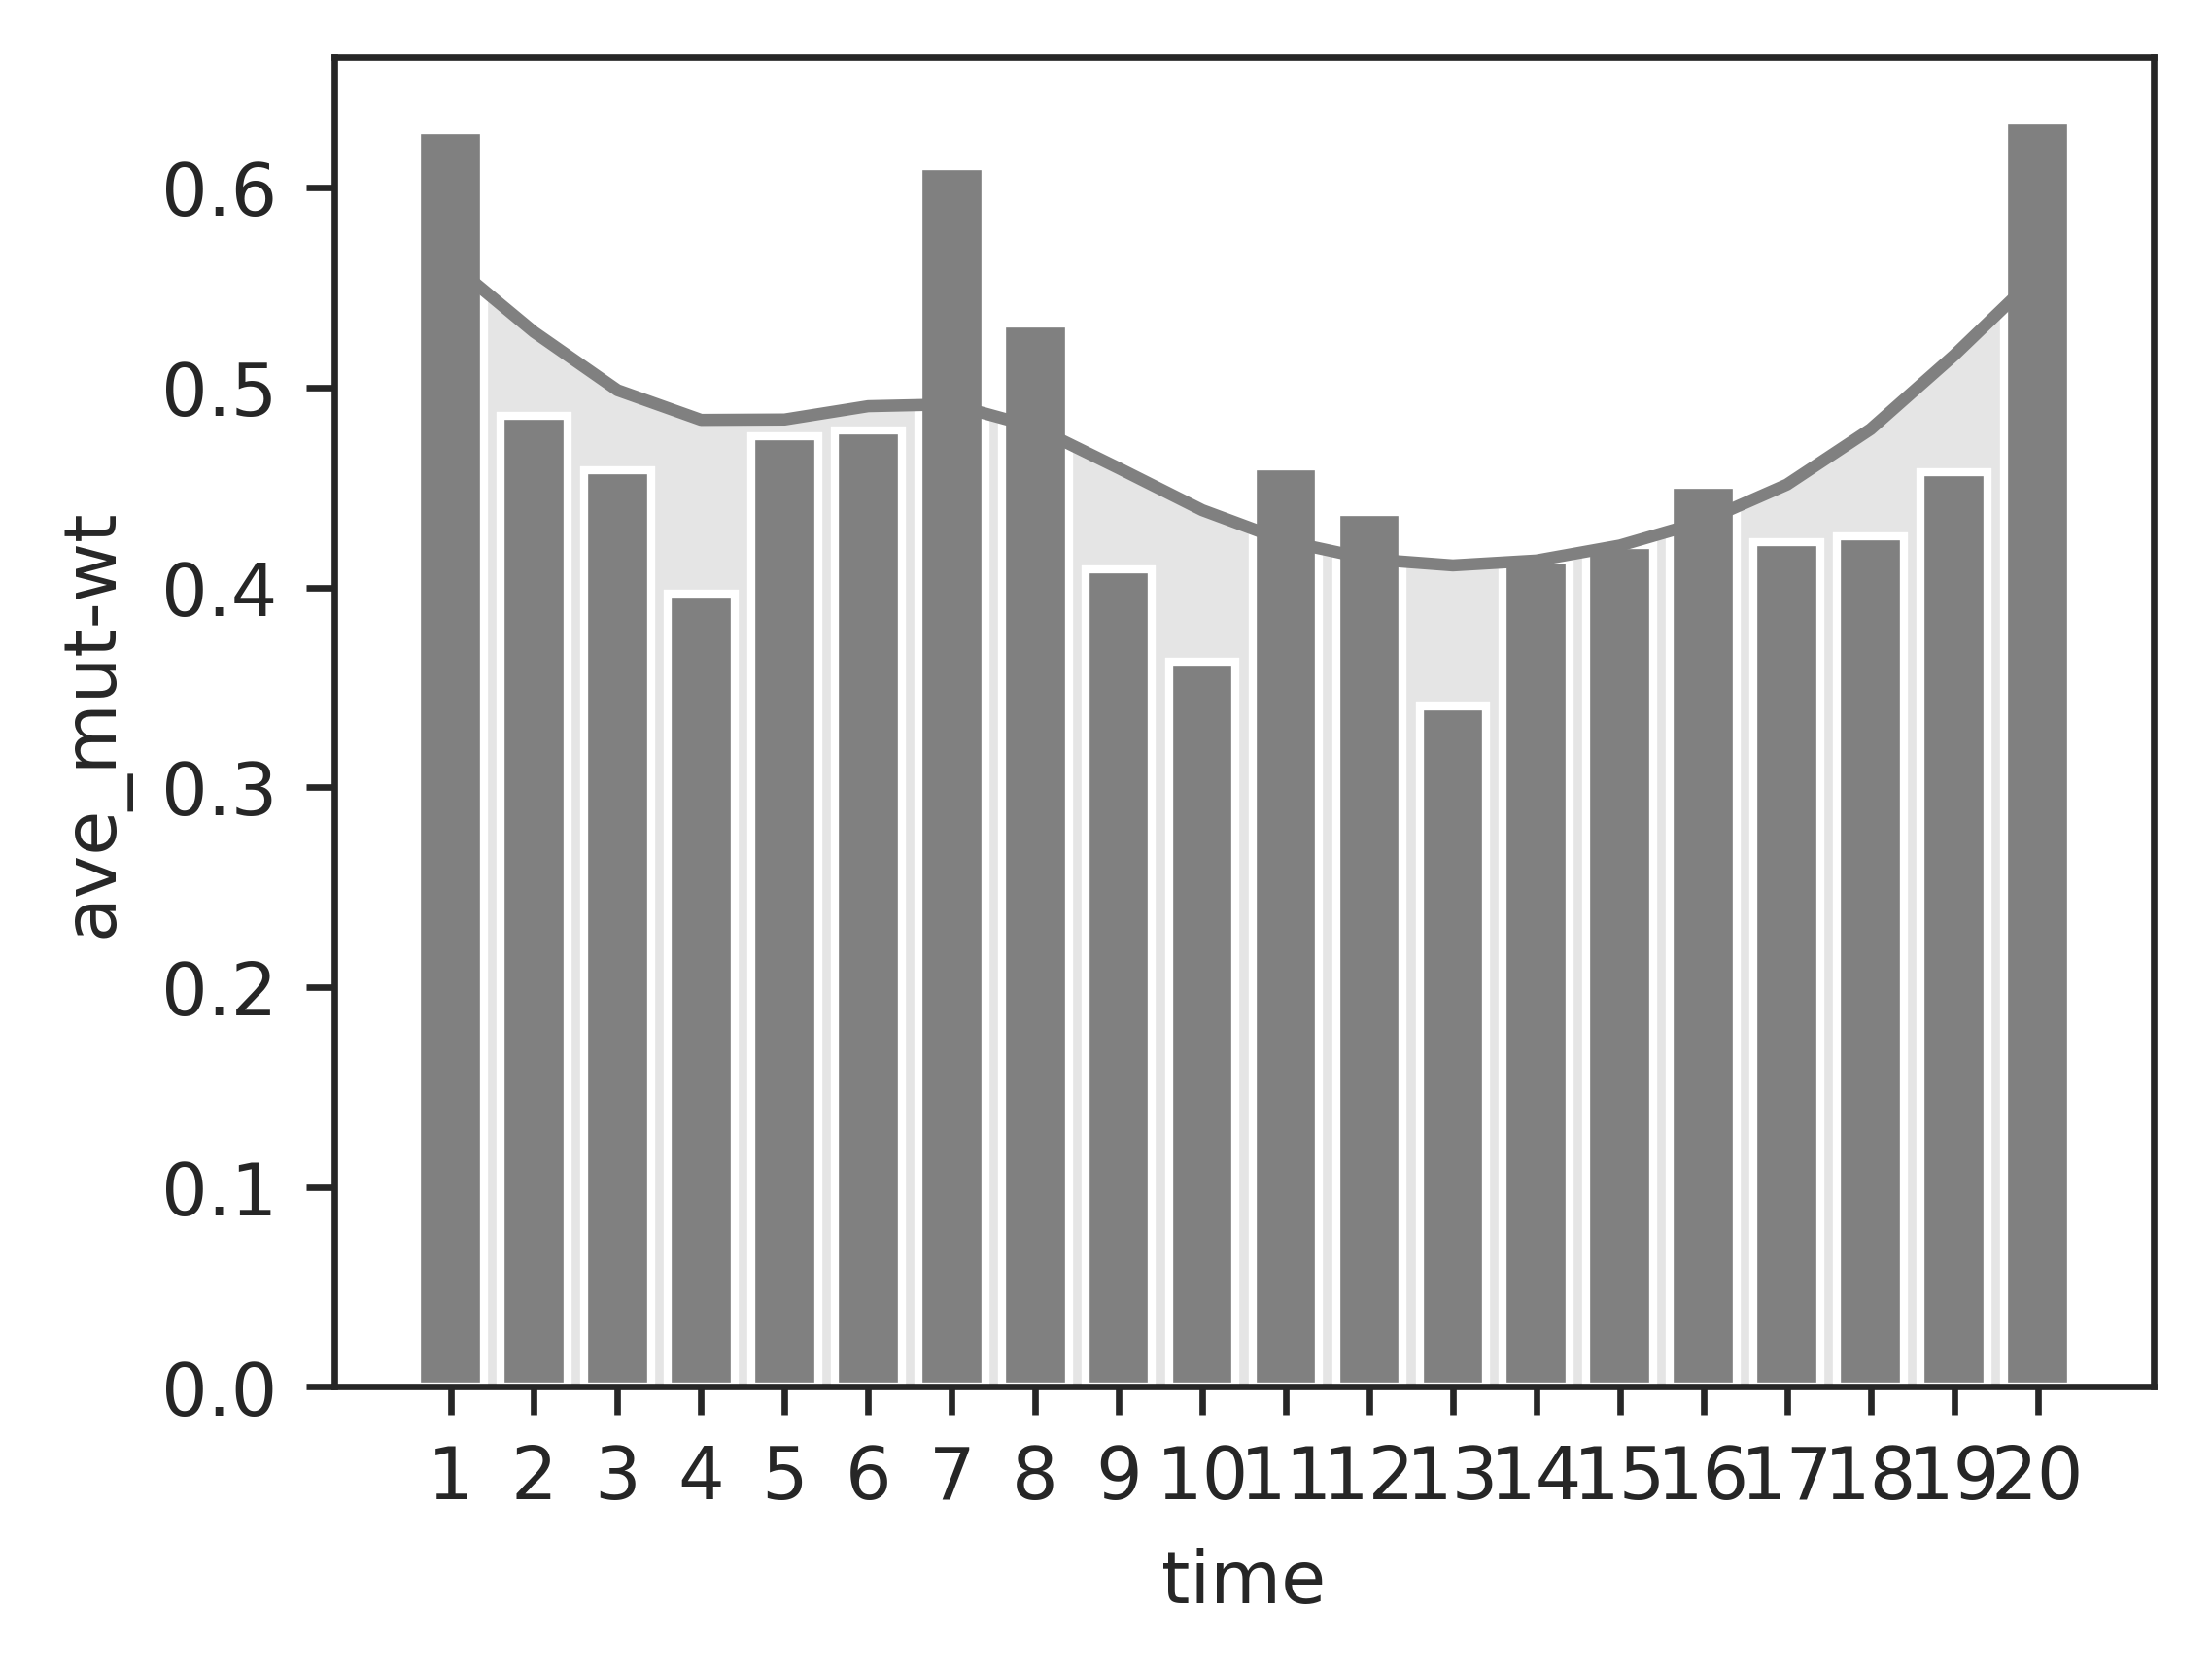

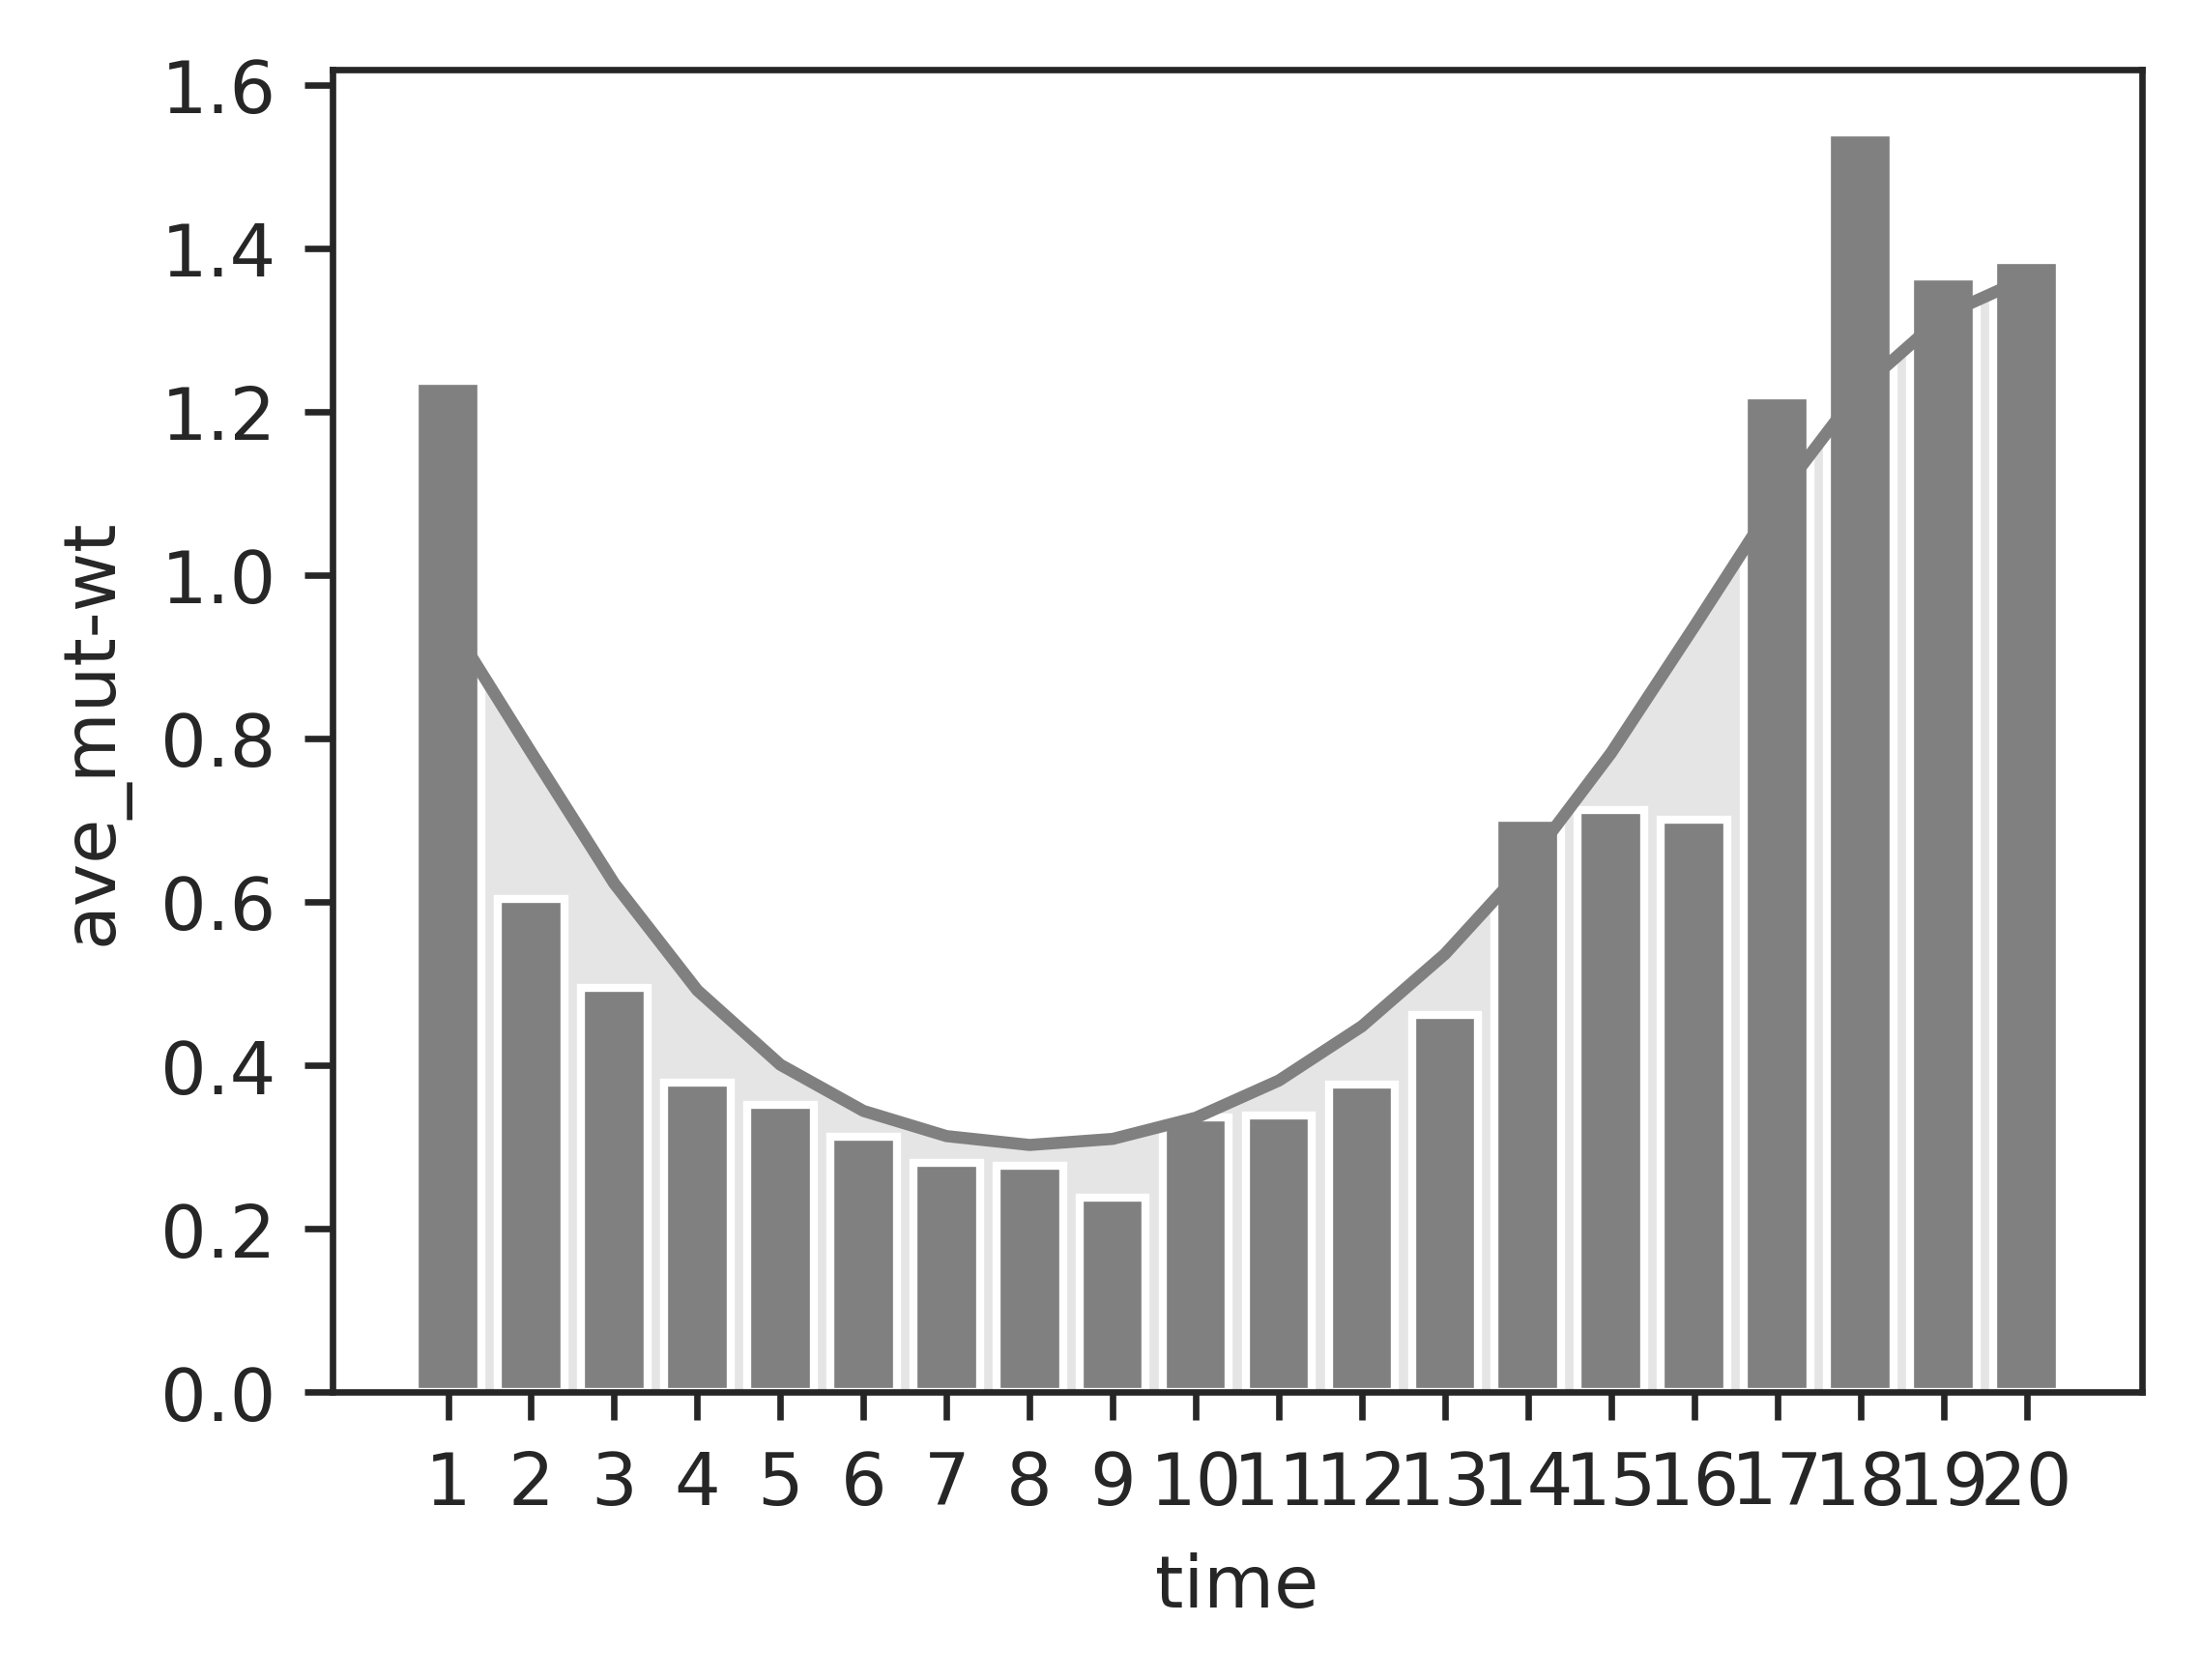

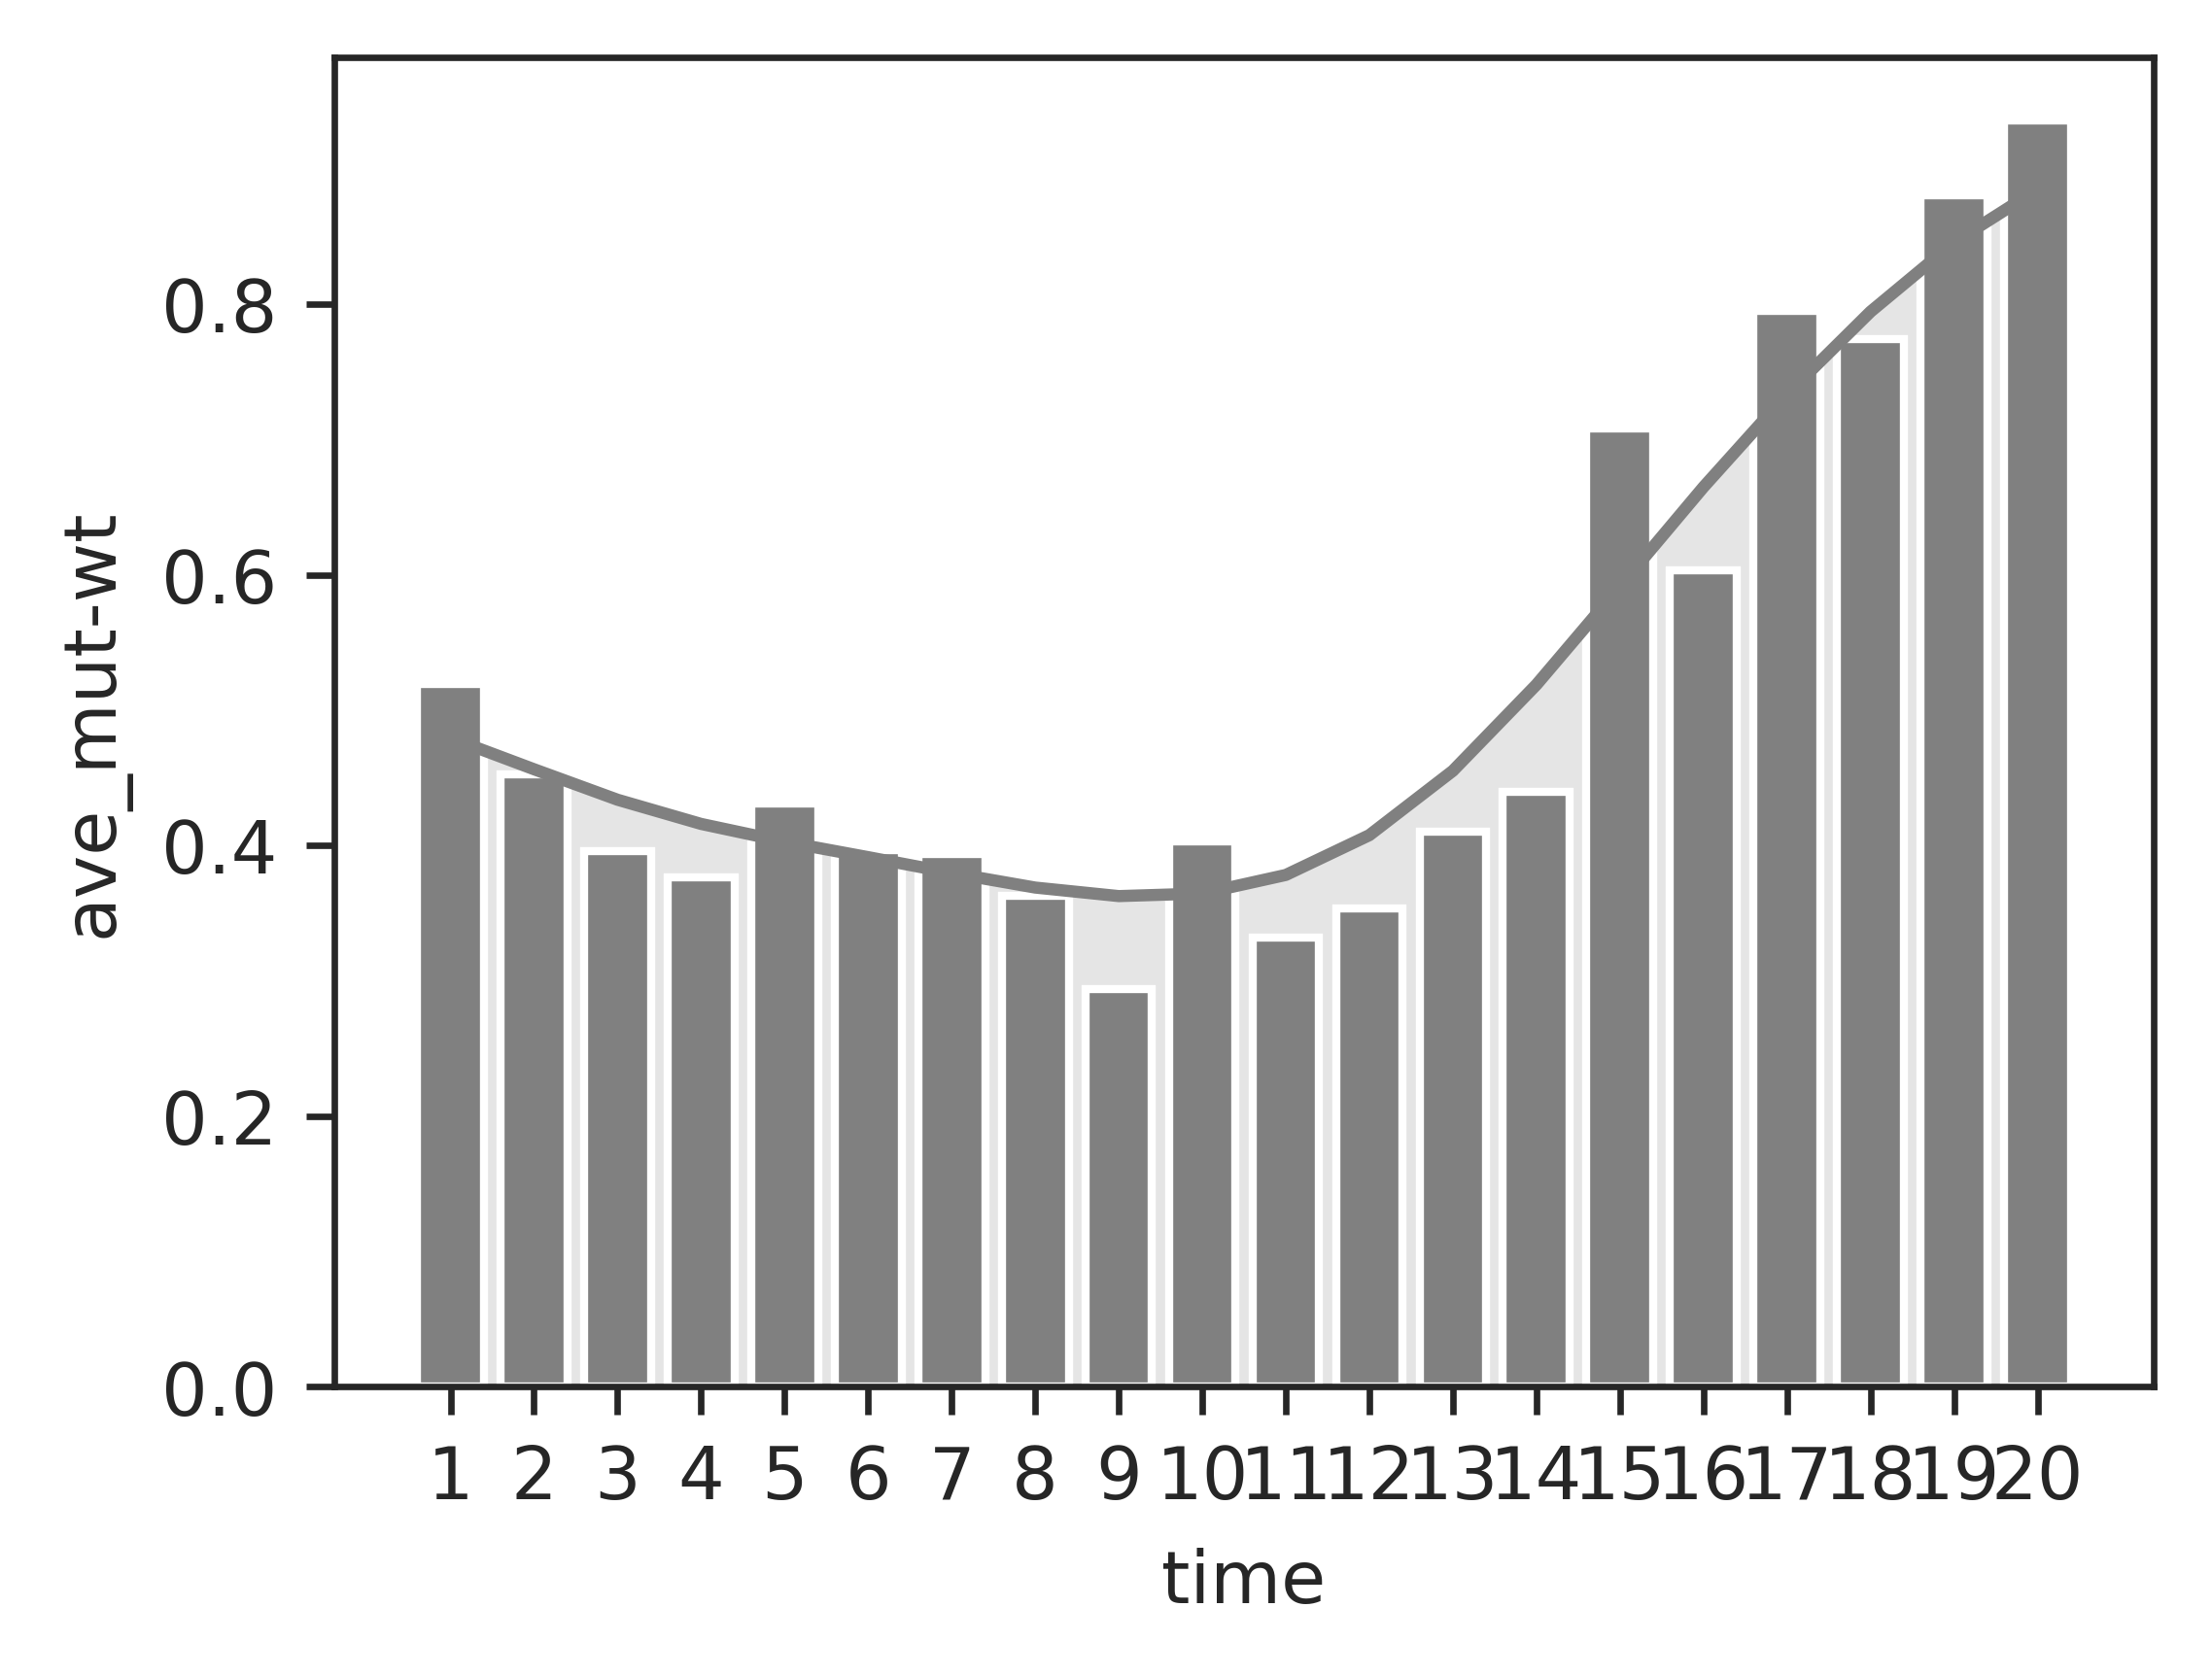

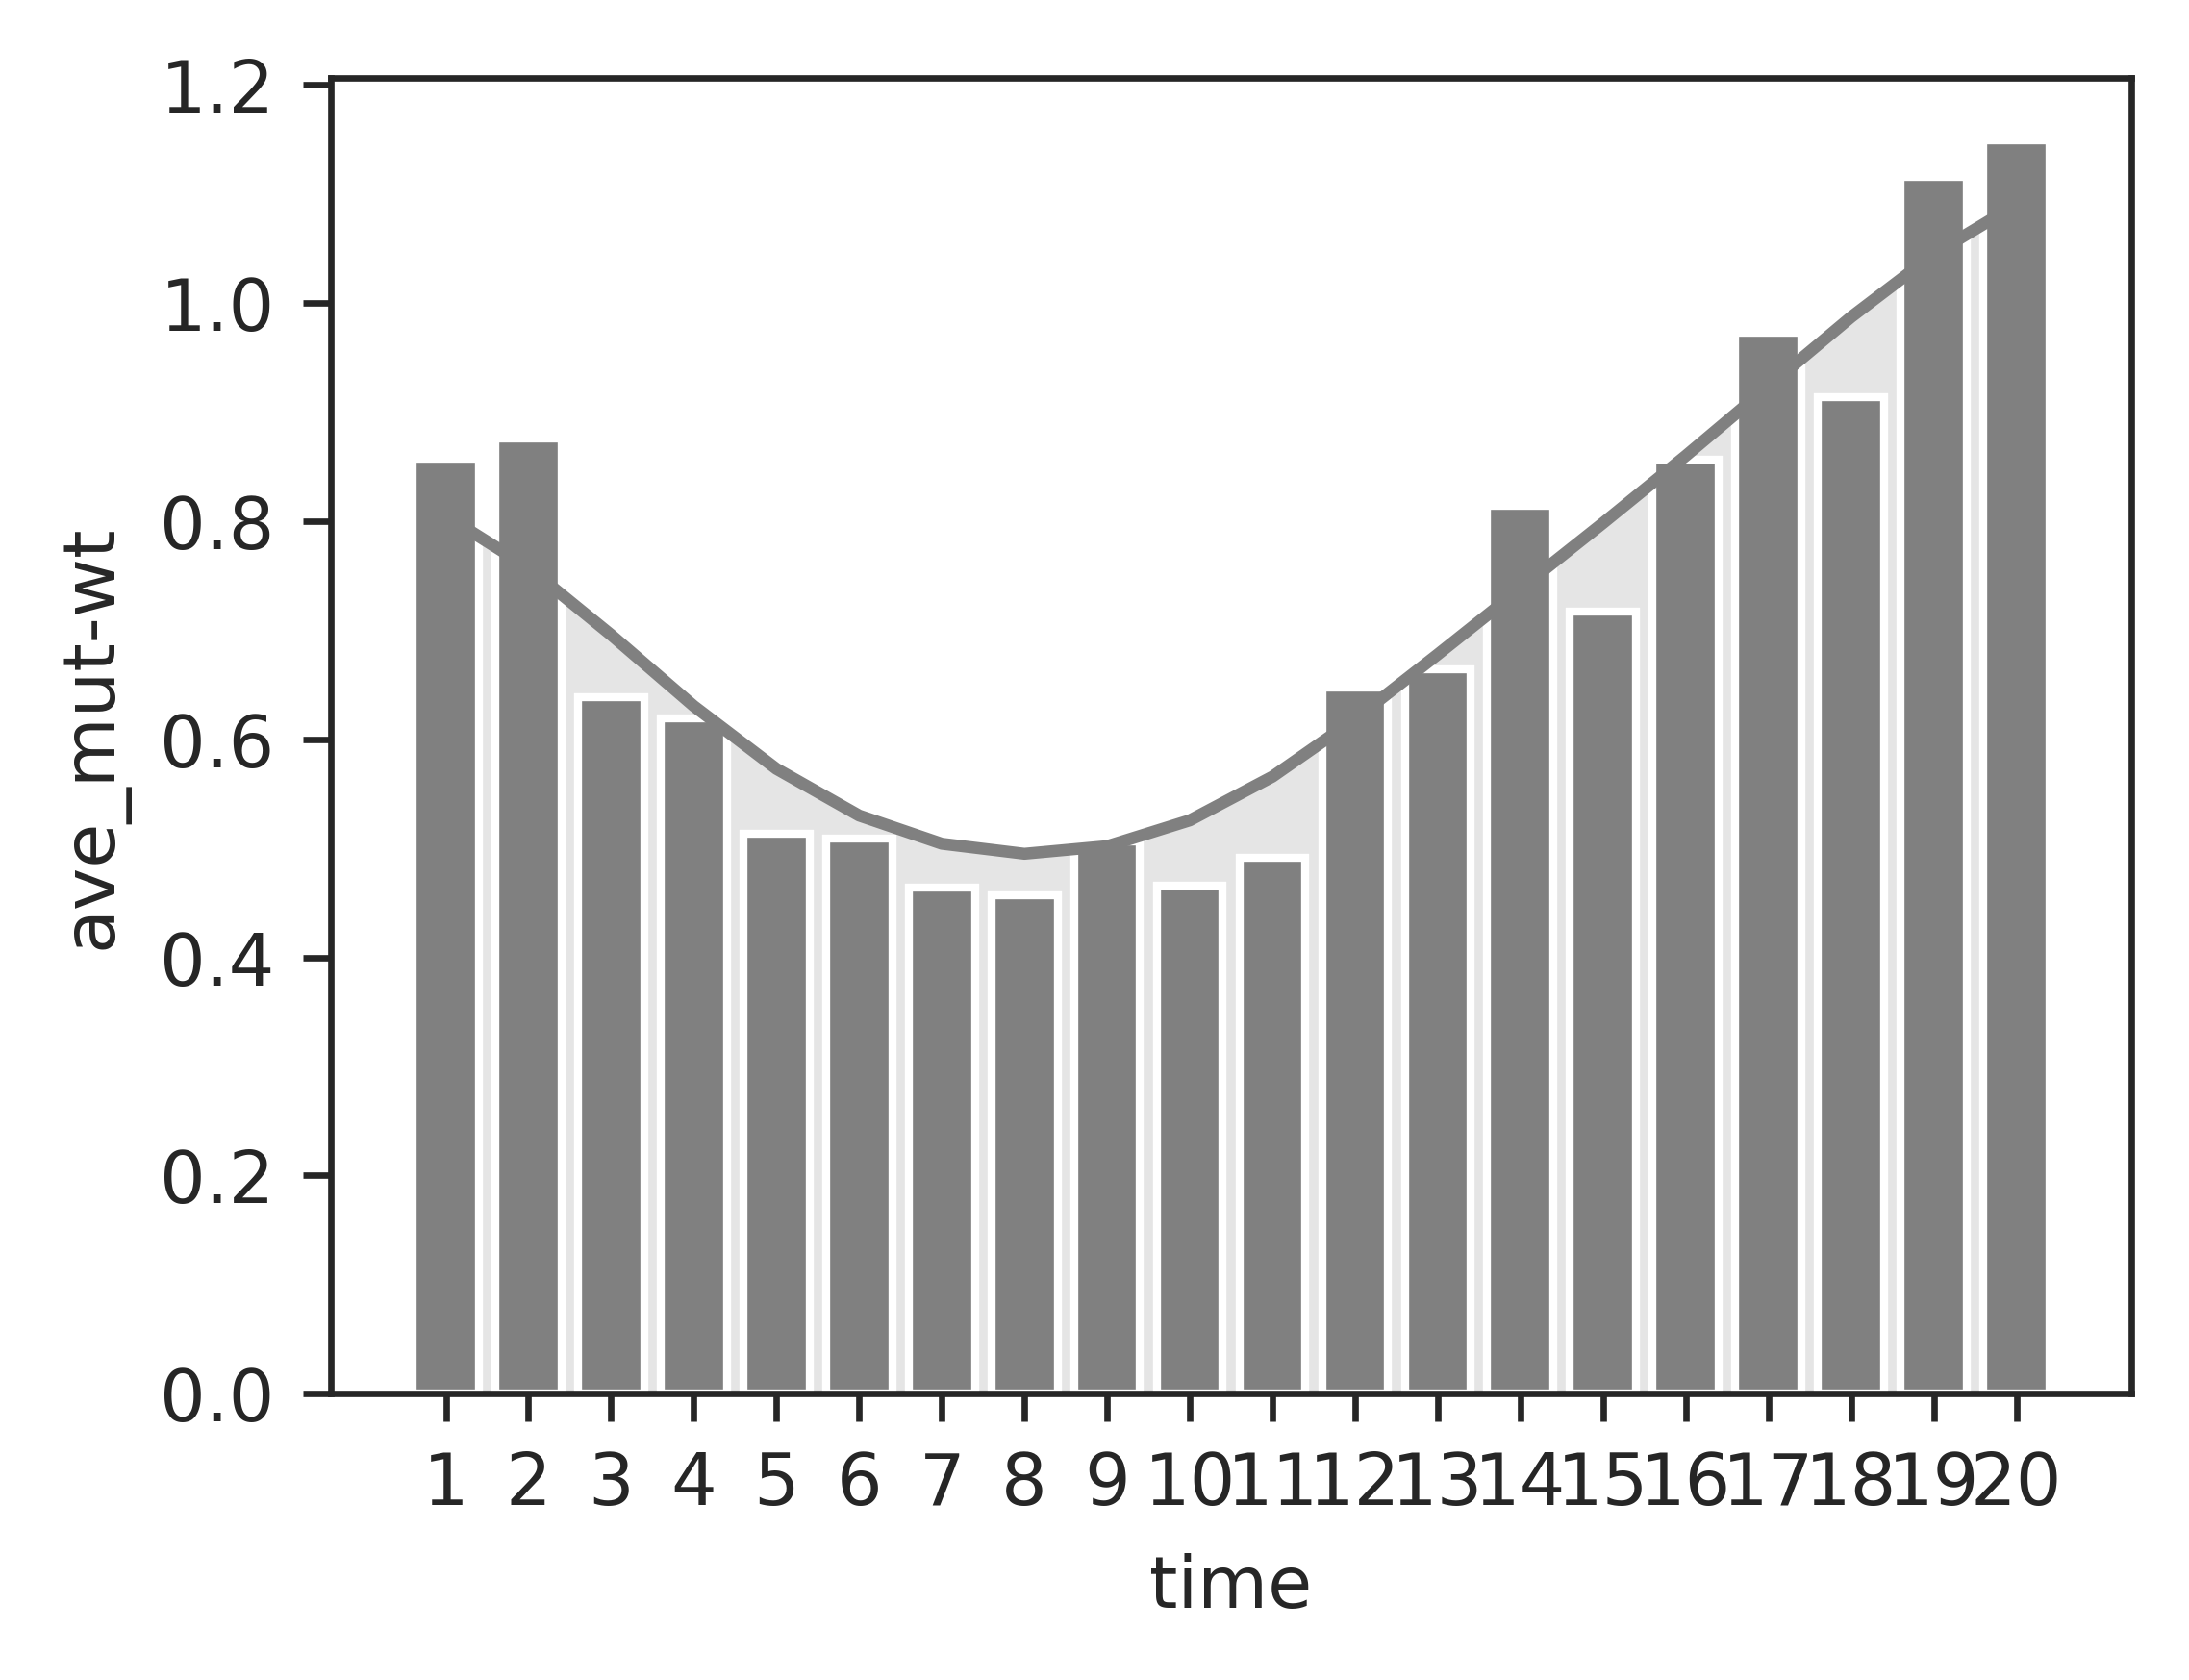

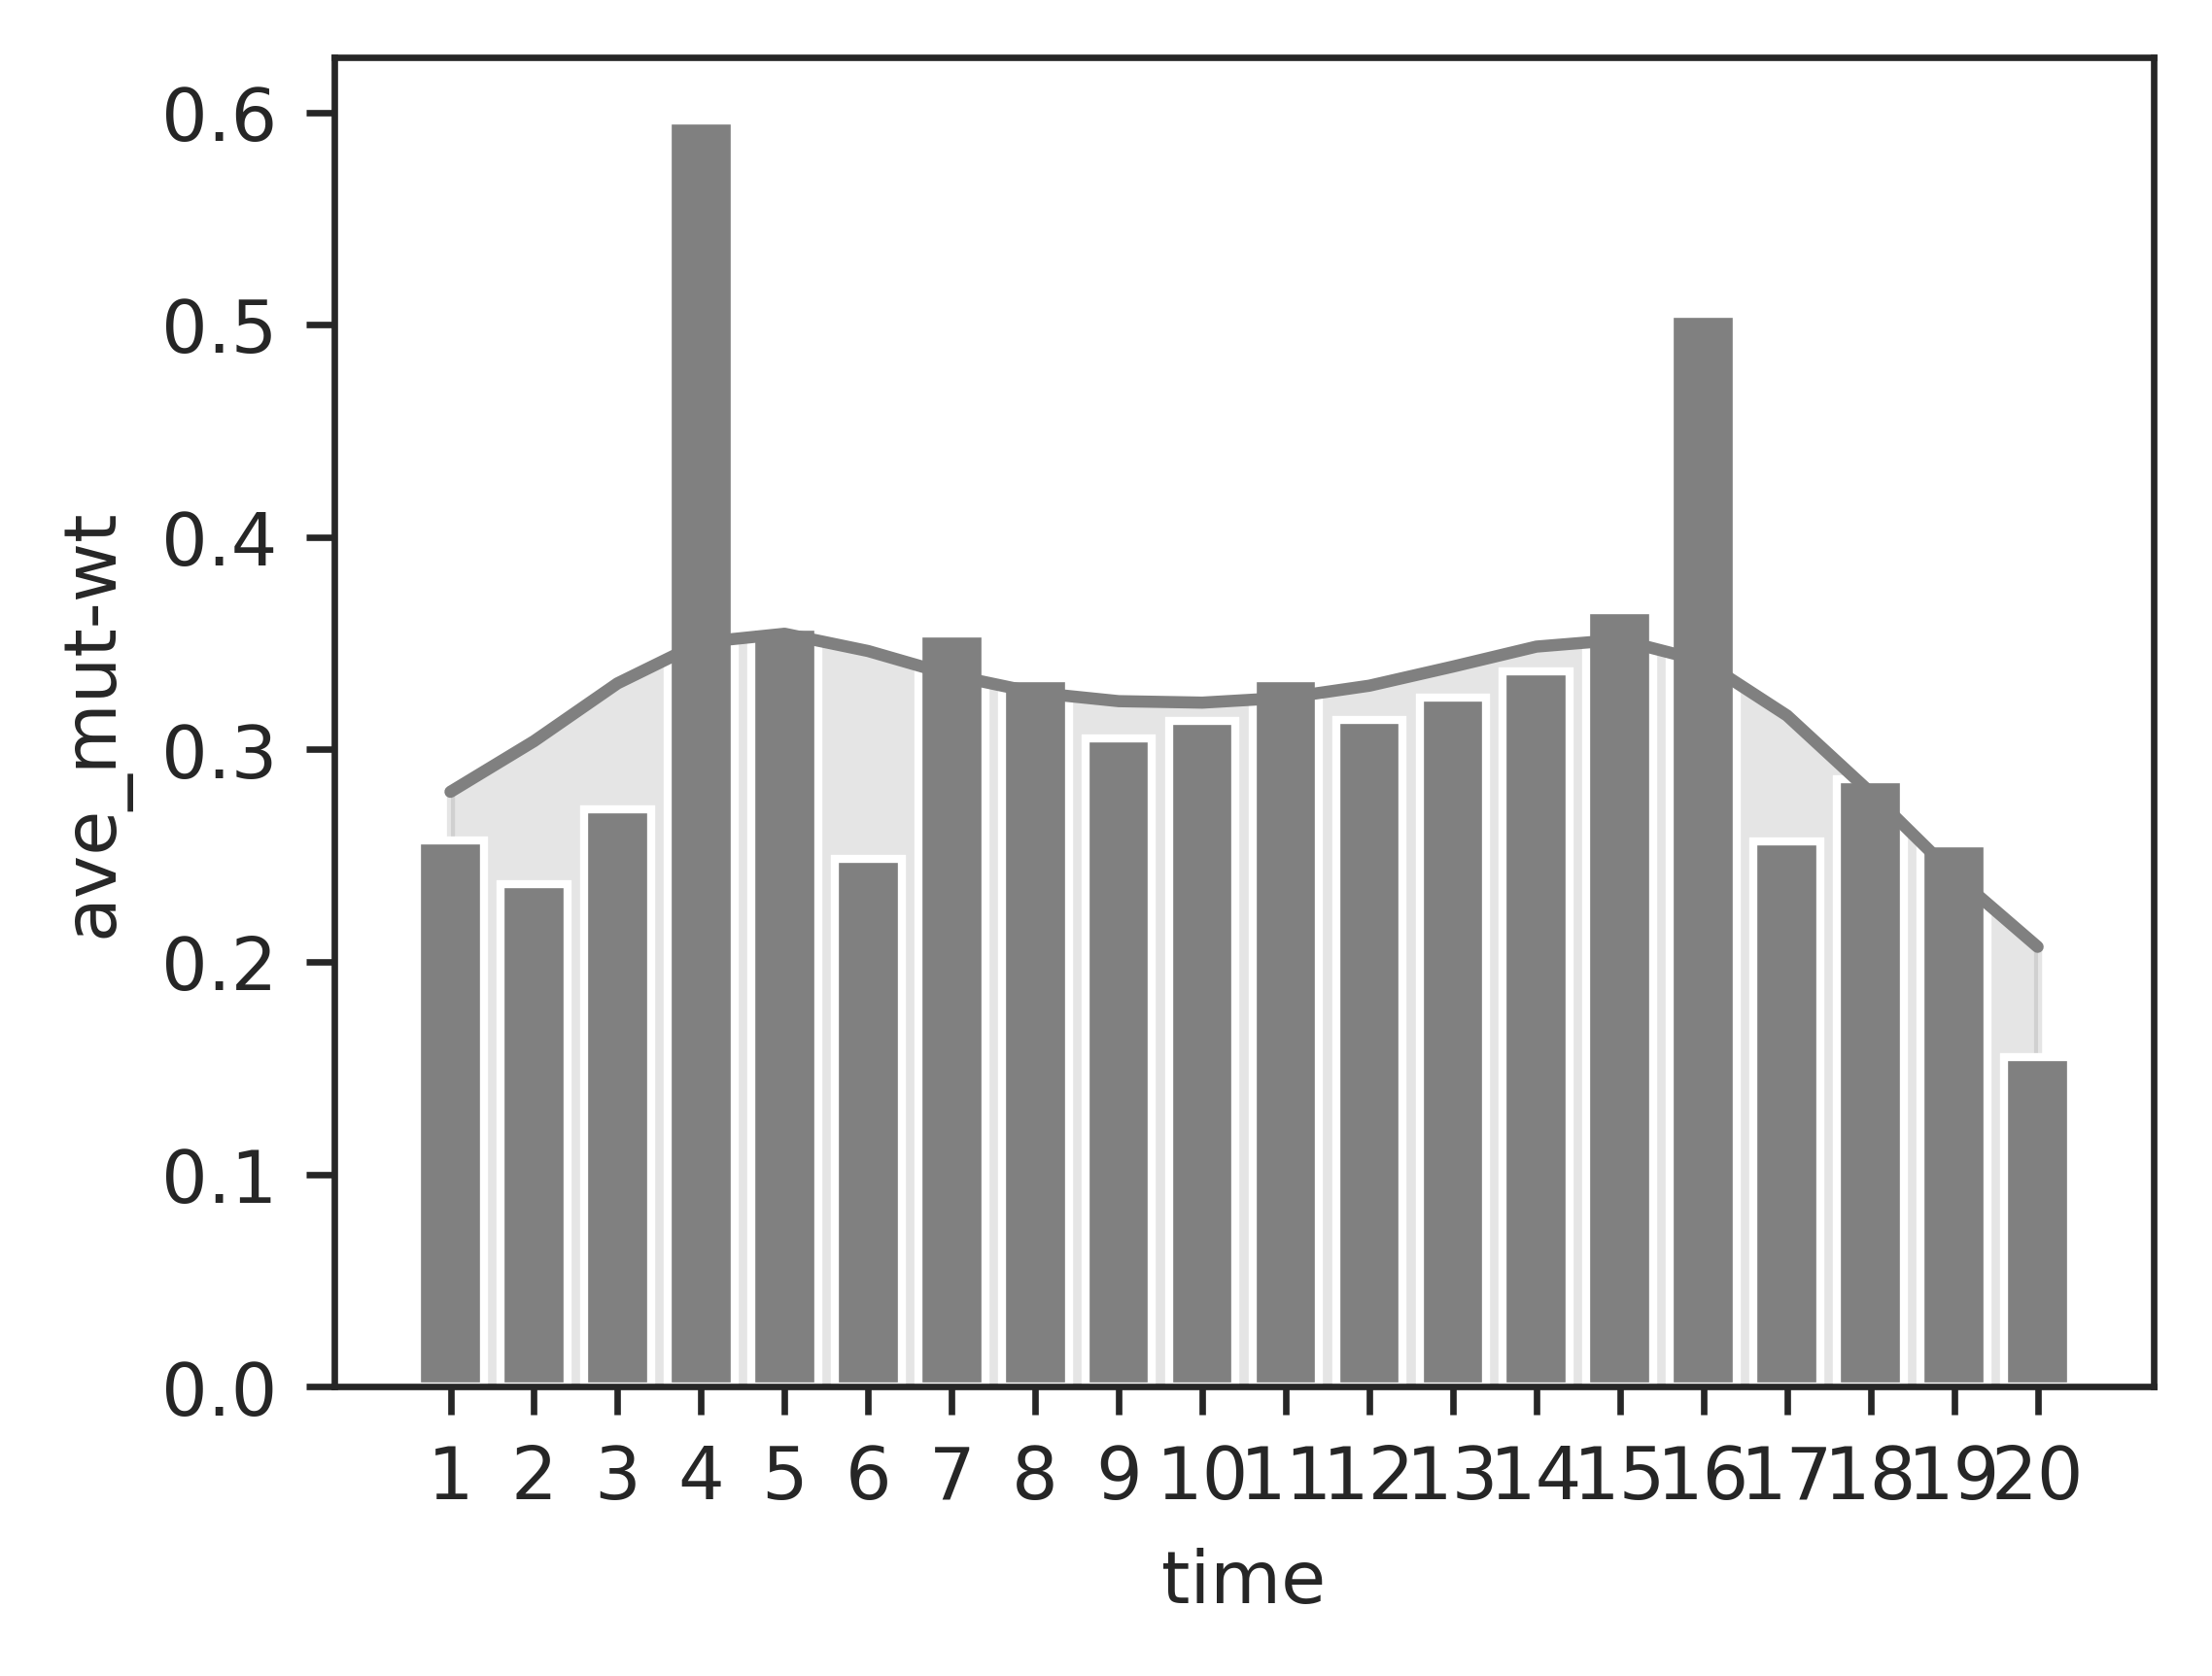

In [36]:
diffs = pd.DataFrame()
for i in x['ctype'].unique():
    x_diff = x.loc[x['ctype']==i, [str(ii) for ii in range(1, ntimebins+1)]+['index']].set_index('index')

    x_diff_melted = x_diff.T.reset_index().rename(columns={'index':'time'})
    x_diff_melted['time'] = x_diff_melted['time'].astype(int)

    x_diff_melted = x_diff_melted.melt(id_vars='time', var_name='topGenes', value_name='mut-wt')
    
    plotting = False

    z = x_diff.abs().mean(axis=0).reset_index().rename(columns={'index':'time'})
    z['time'] = z['time'].astype(int)
    z = z.rename(columns={0:'ave_mut-wt'})

    # smoothed
    yprime = gaussian_filter1d(
        z['ave_mut-wt'],
        2,
        axis=-1,
        order=0,
        output=None,
        mode='nearest',
        cval=0.0,
        truncate=4.0,
    )
    
    if plotting:
        fig, ax = plt.subplots(1,1, figsize=(4,3))
        sns.barplot(x='time', y='ave_mut-wt', data=z, color='gray', ax=ax)
        ax.plot(z['time']-1, yprime, color='gray')
        ax.fill_between(z['time']-1, 0, yprime, color='gray', alpha=0.2)

    dt = pd.DataFrame({'time':z['time'] - 1, 'ave_mut-wt':yprime})
    dt['ctype'] = i

    diffs = diffs.append(dt, ignore_index=True)

In [38]:
# aesthetics 
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE'}

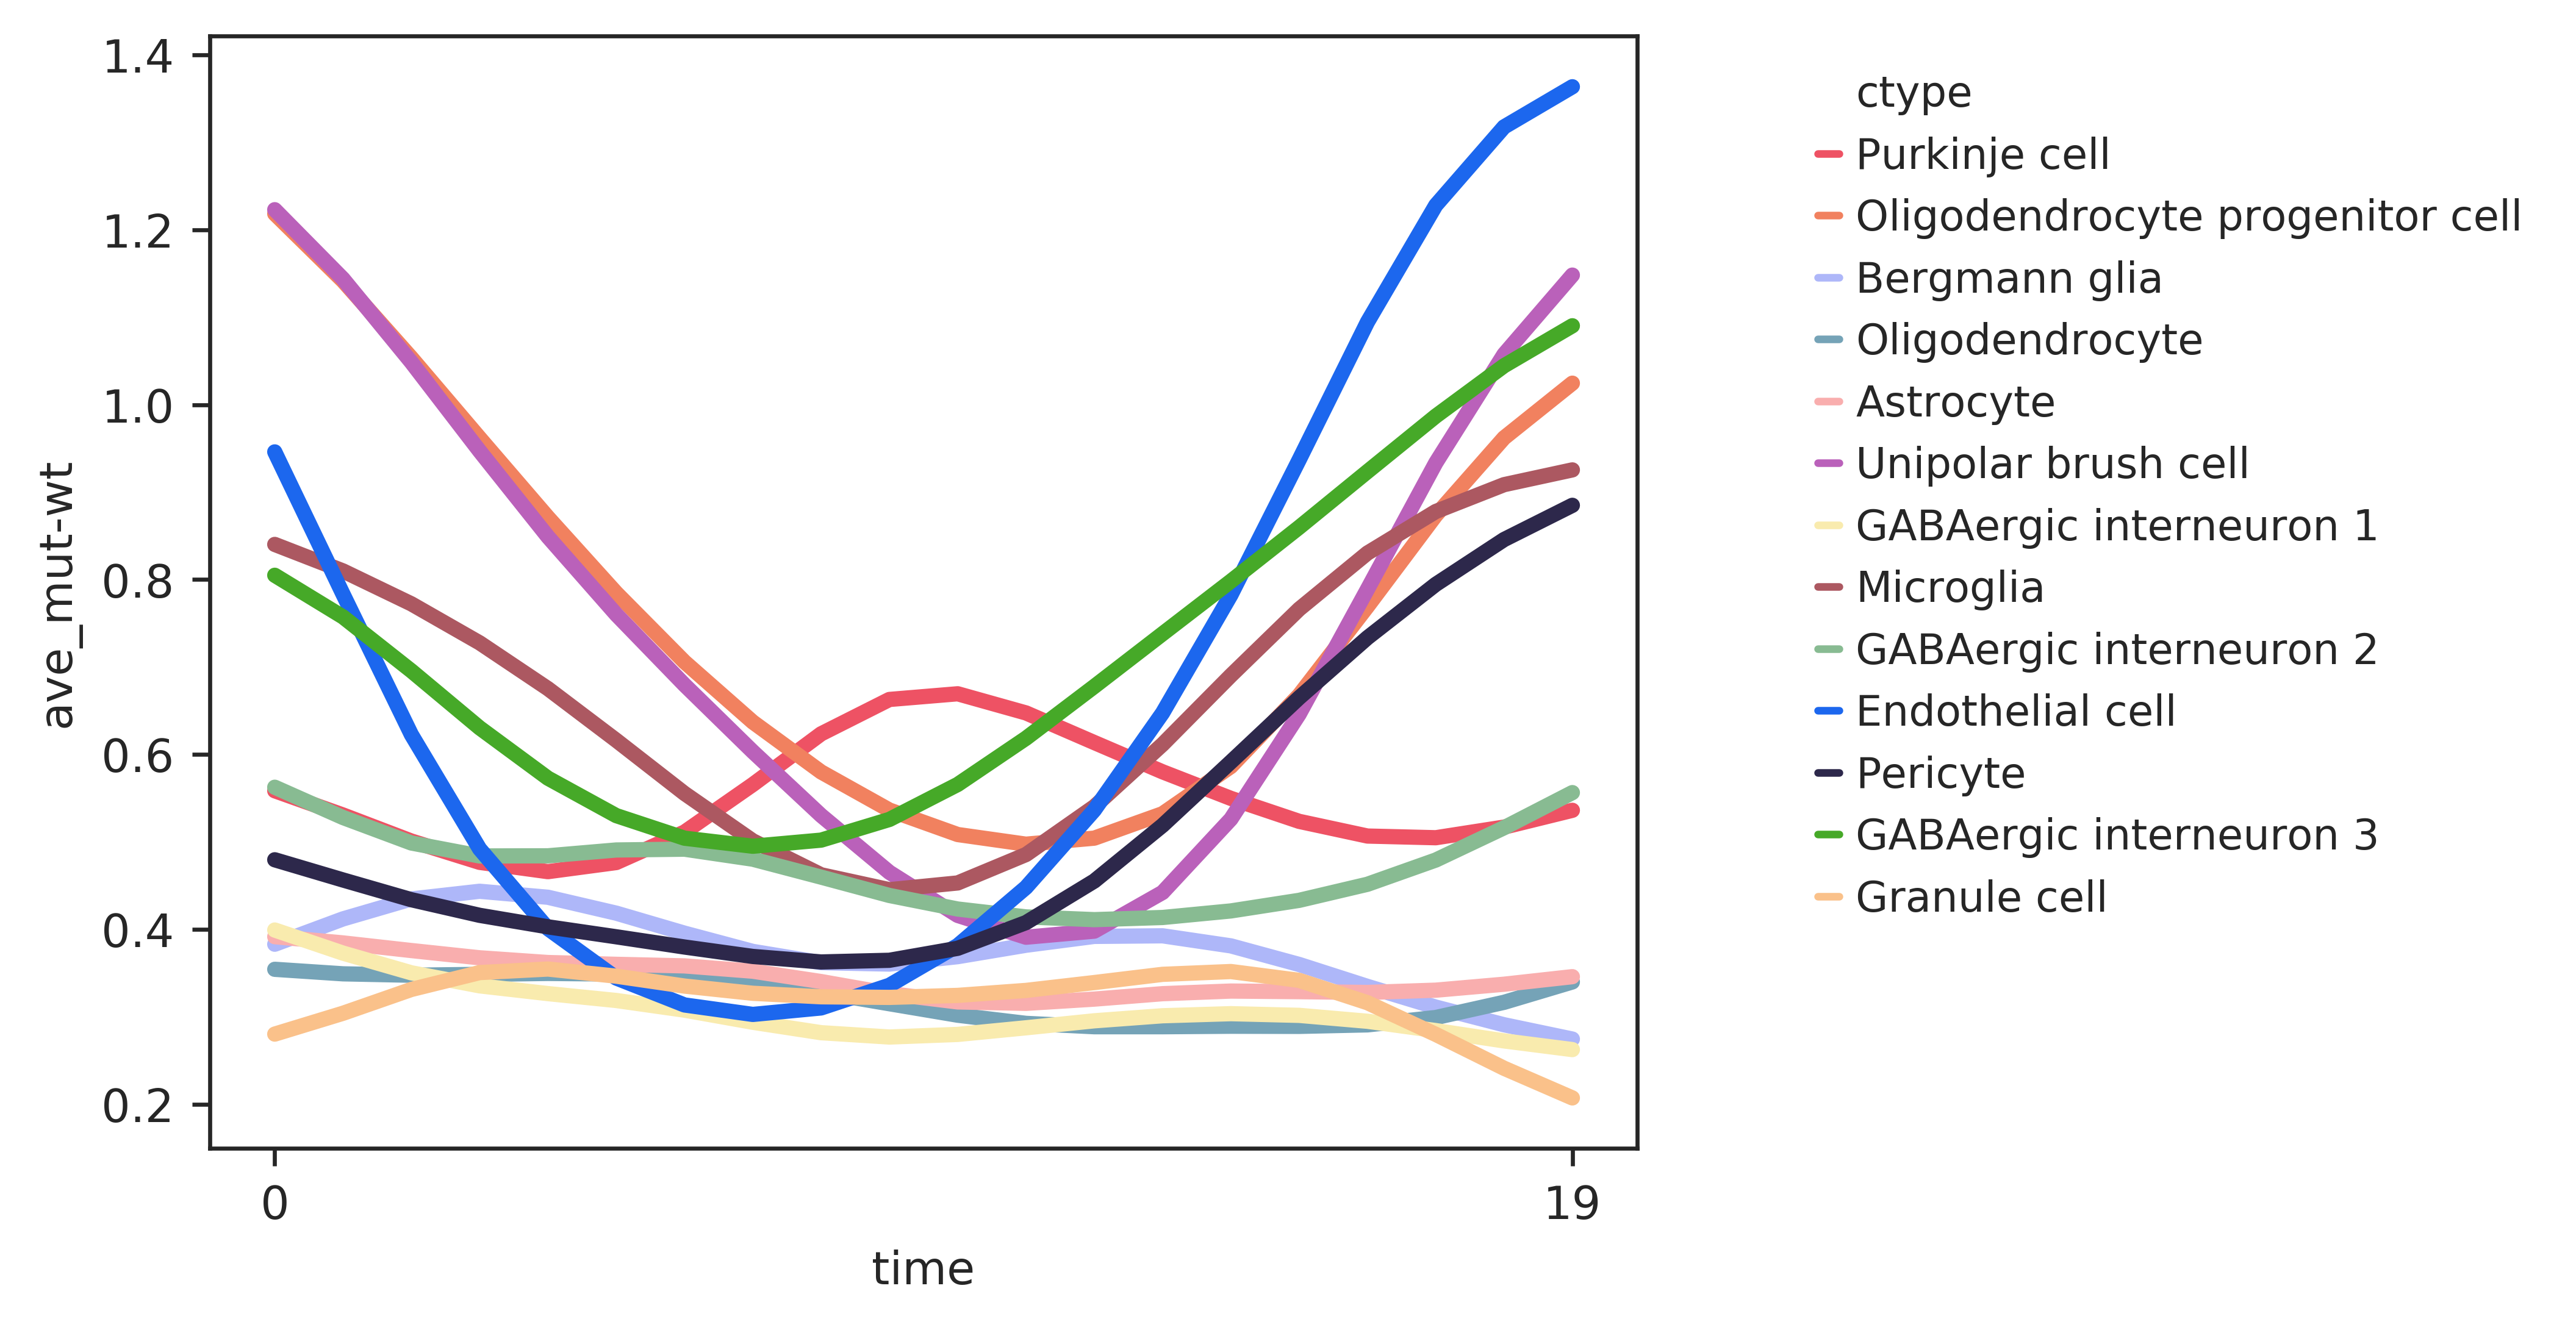

In [53]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.lineplot(x='time', y='ave_mut-wt', hue='ctype', size=None, 
                 style=None, data=diffs, palette=cmap_ctype, hue_order=None, 
                 hue_norm=None, sizes=None, size_order=None, size_norm=None, 
                 dashes=True, markers=None, style_order=None, 
                 units=None, estimator='mean', ci=95, n_boot=1000, seed=None, sort=True, 
                 err_style='band', err_kws=None, legend='brief', ax=ax, lw=3)
ax.legend(bbox_to_anchor=(1.1,1)).set_title('')
ax.set_xticks([0,19])
fig.savefig(os.path.join(pfp, 'dyn_ctype.pdf'), bbox_inches='tight')